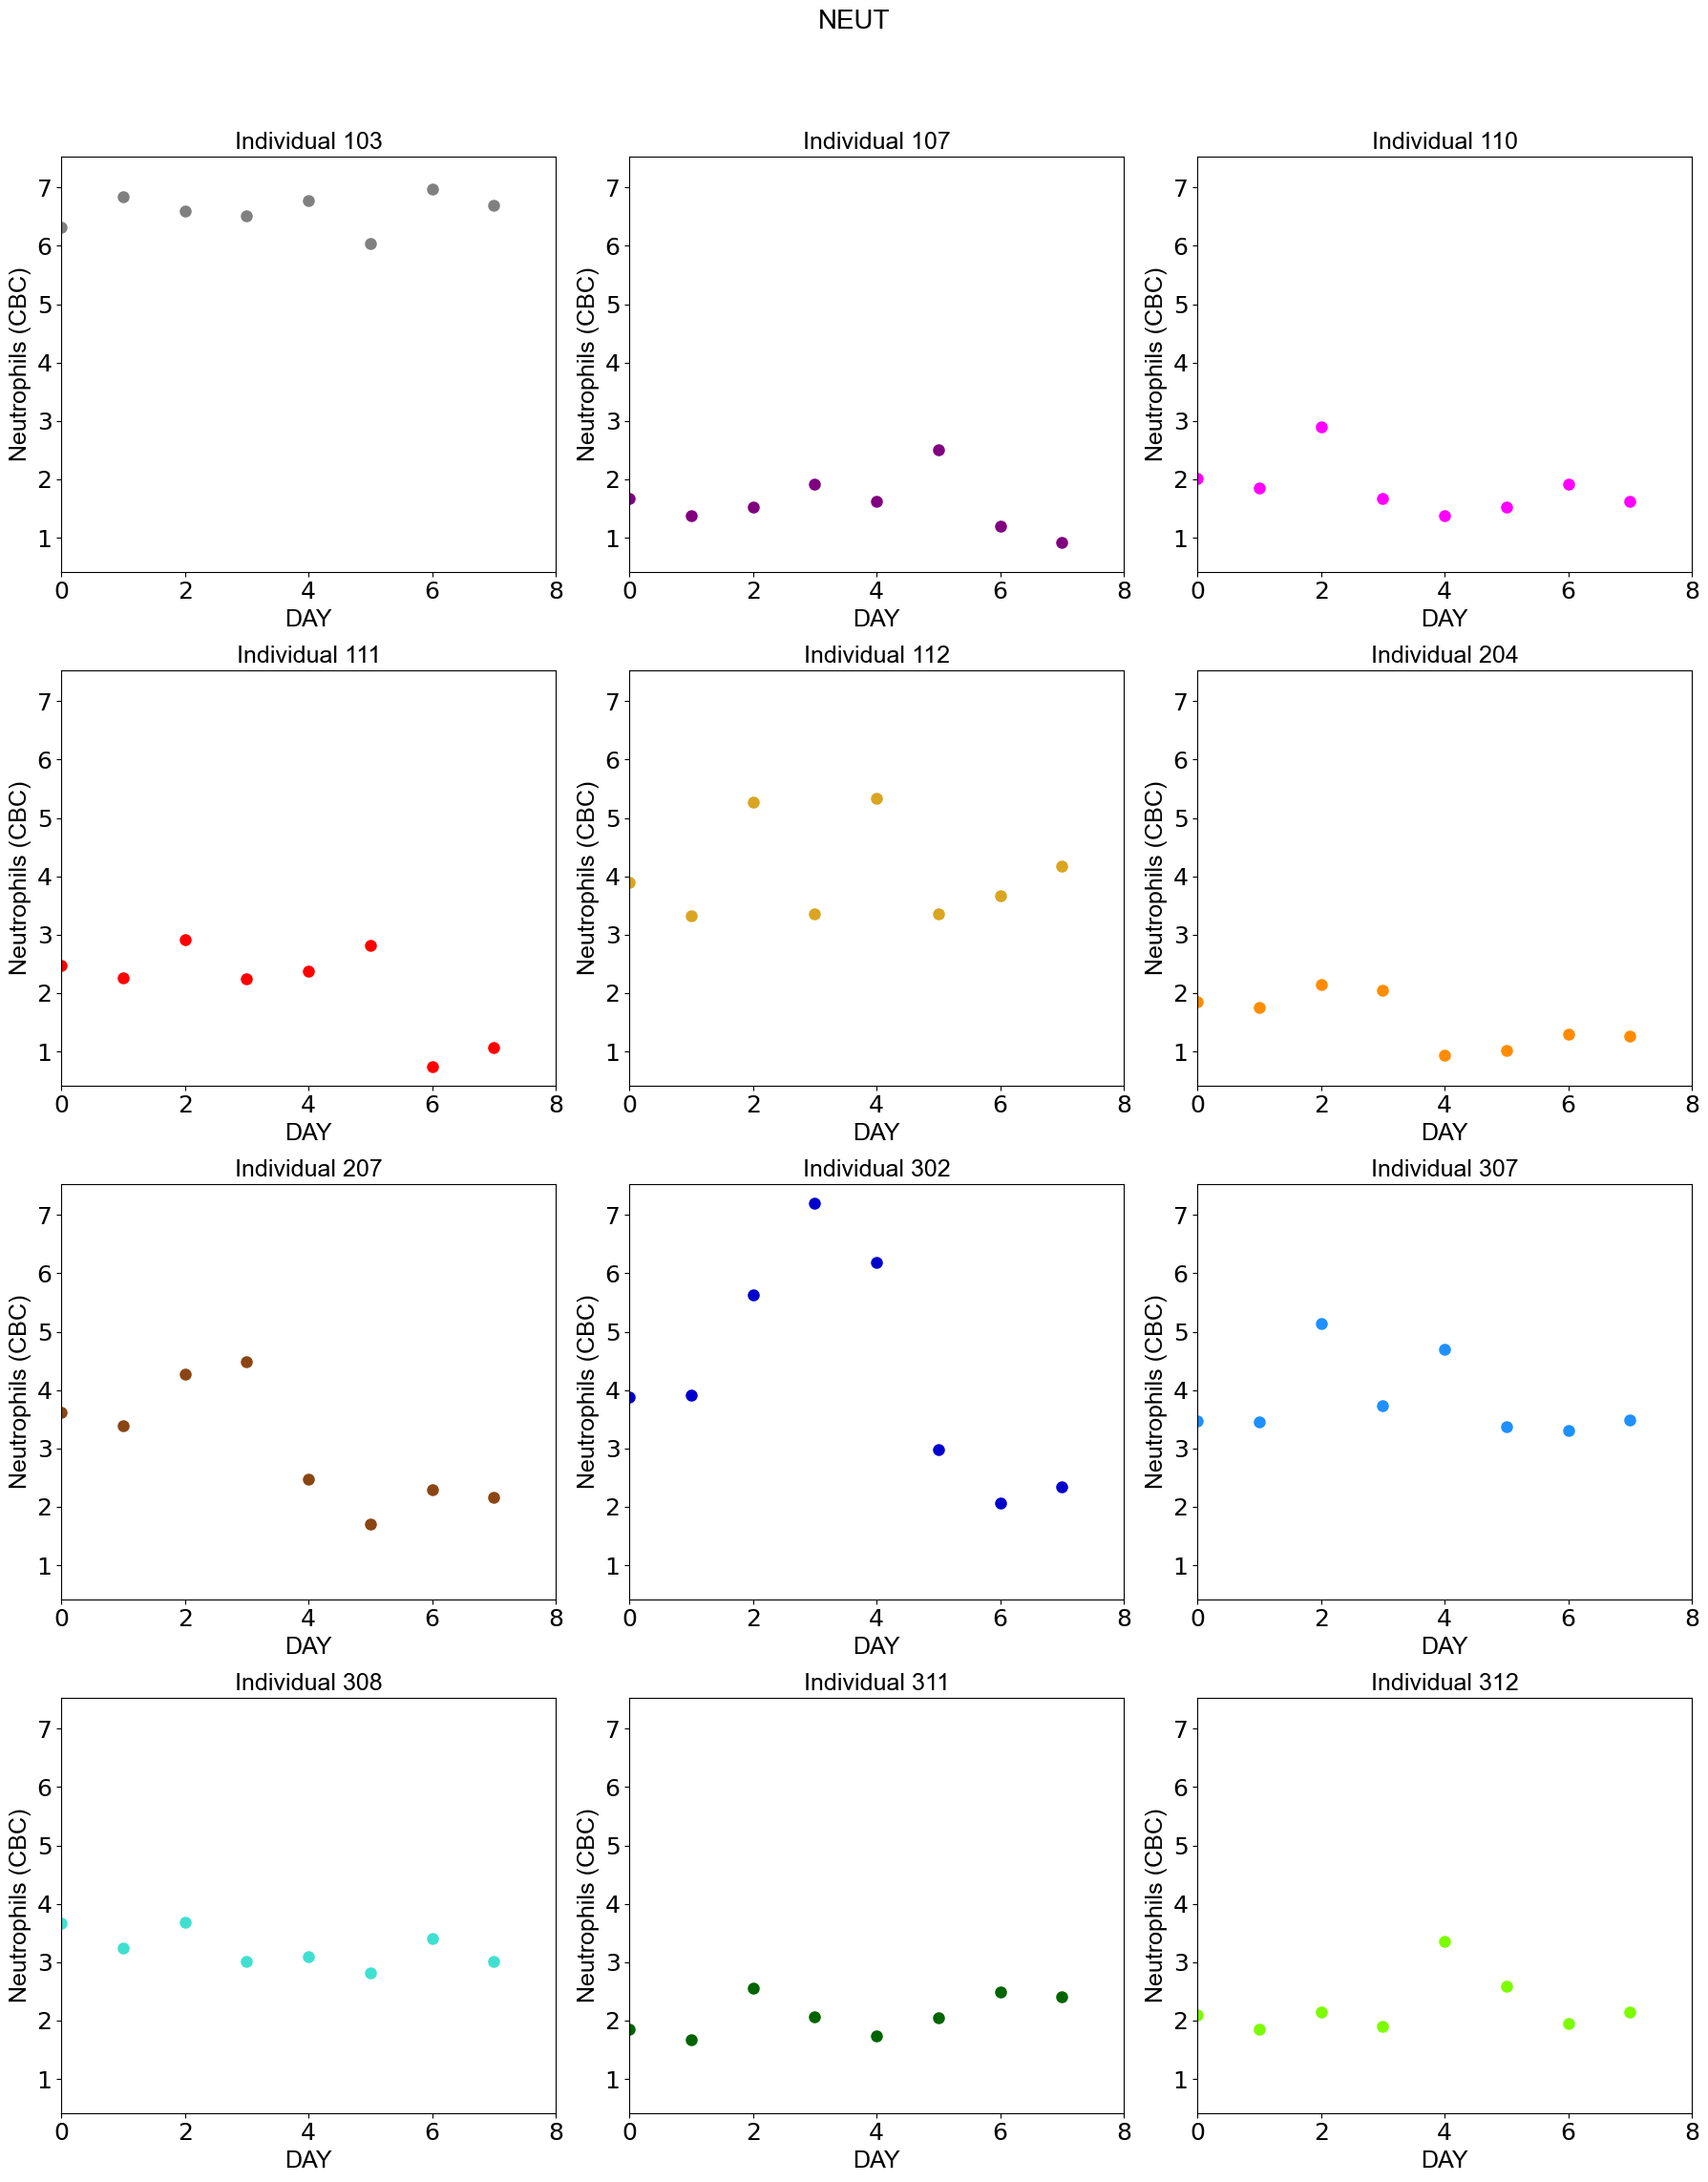

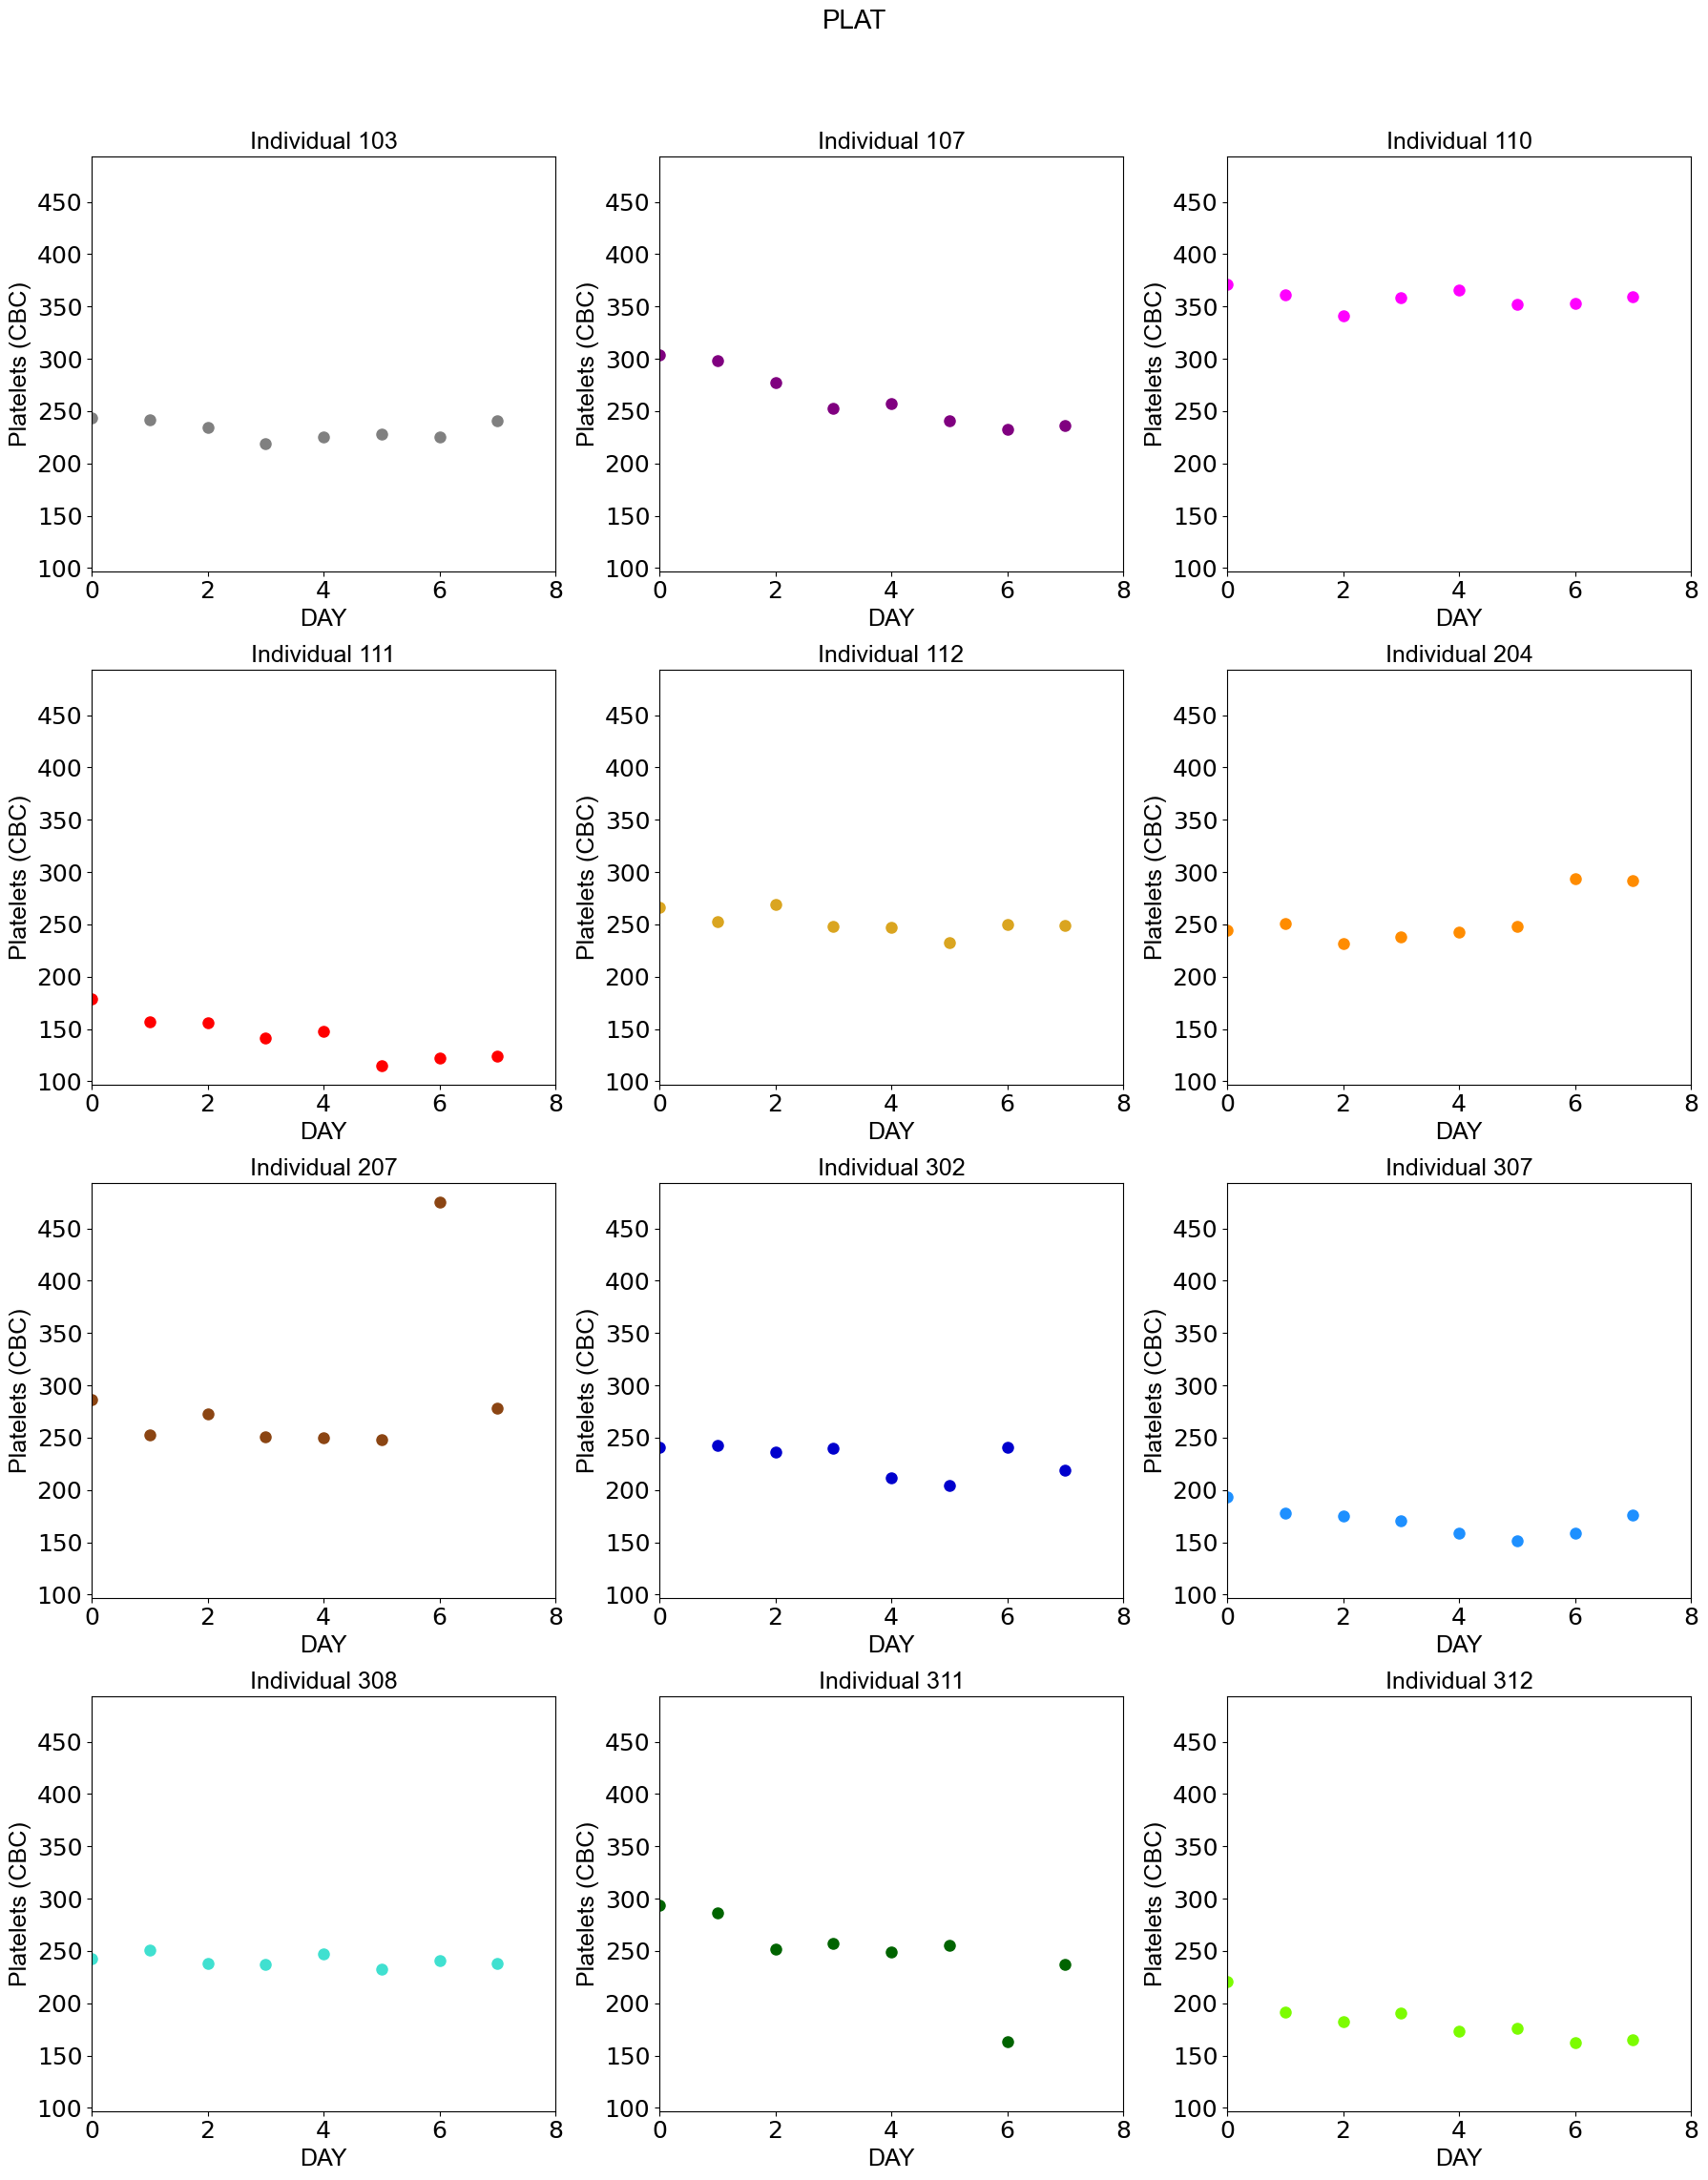

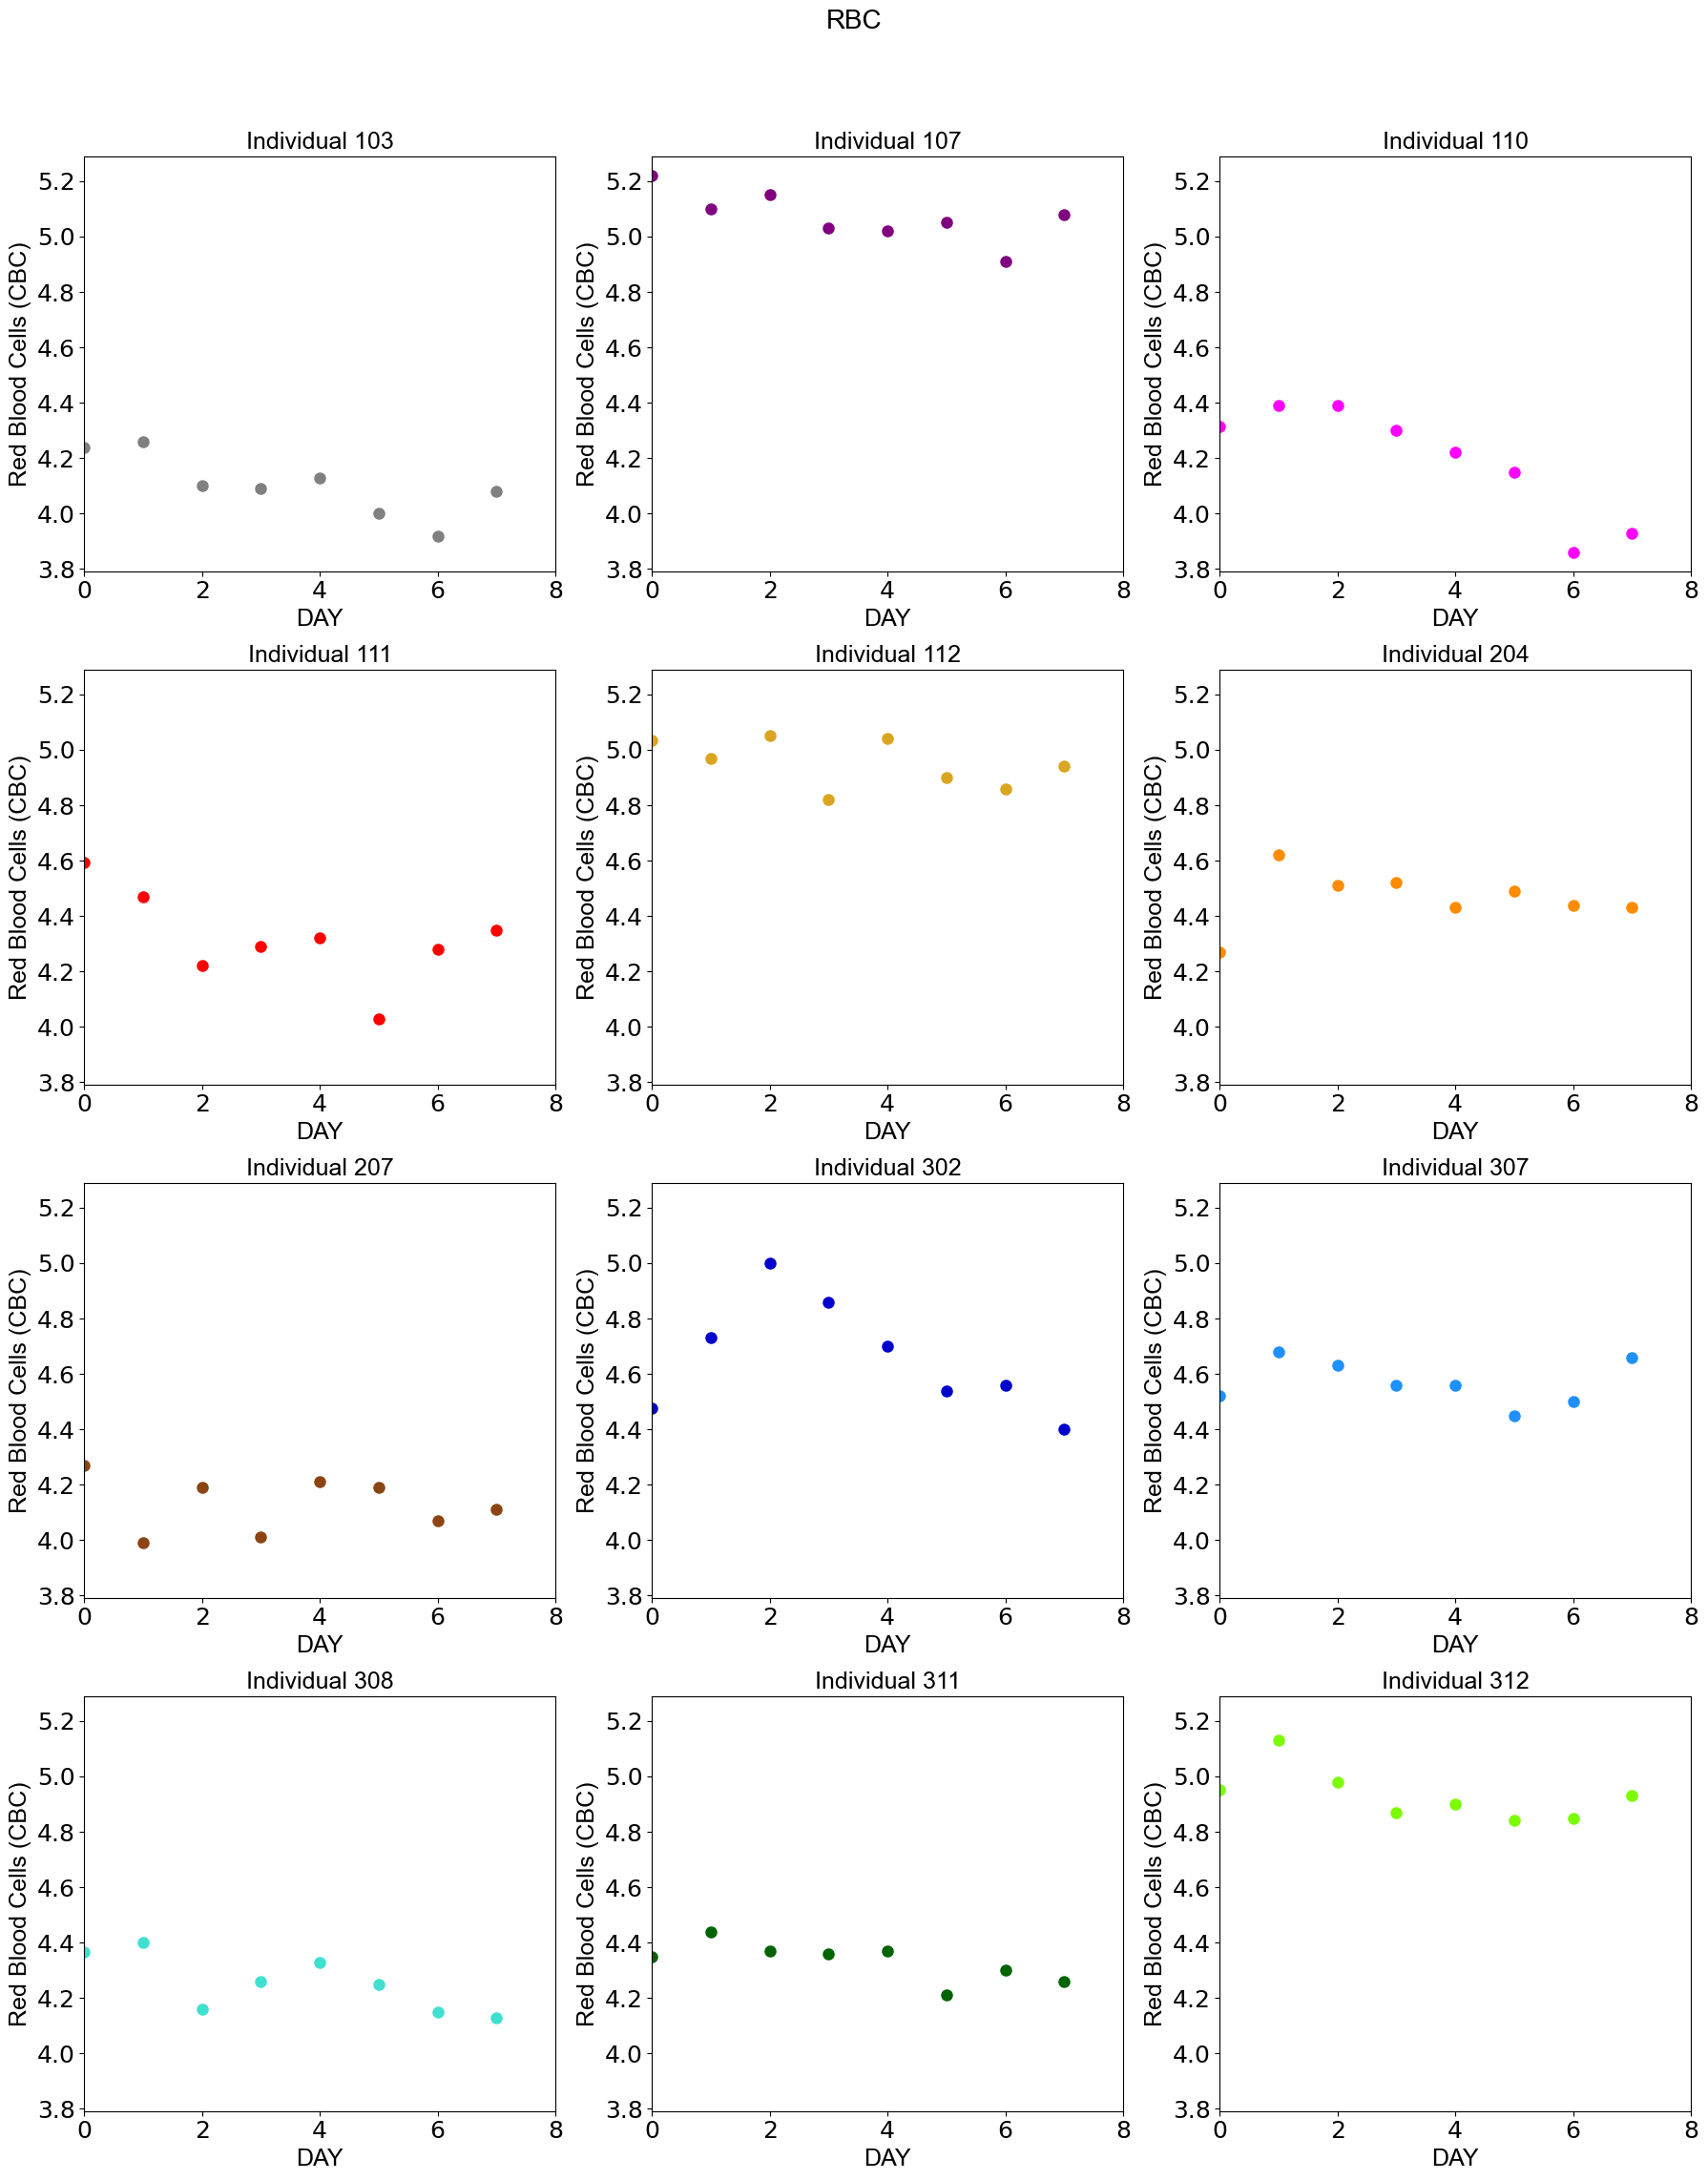

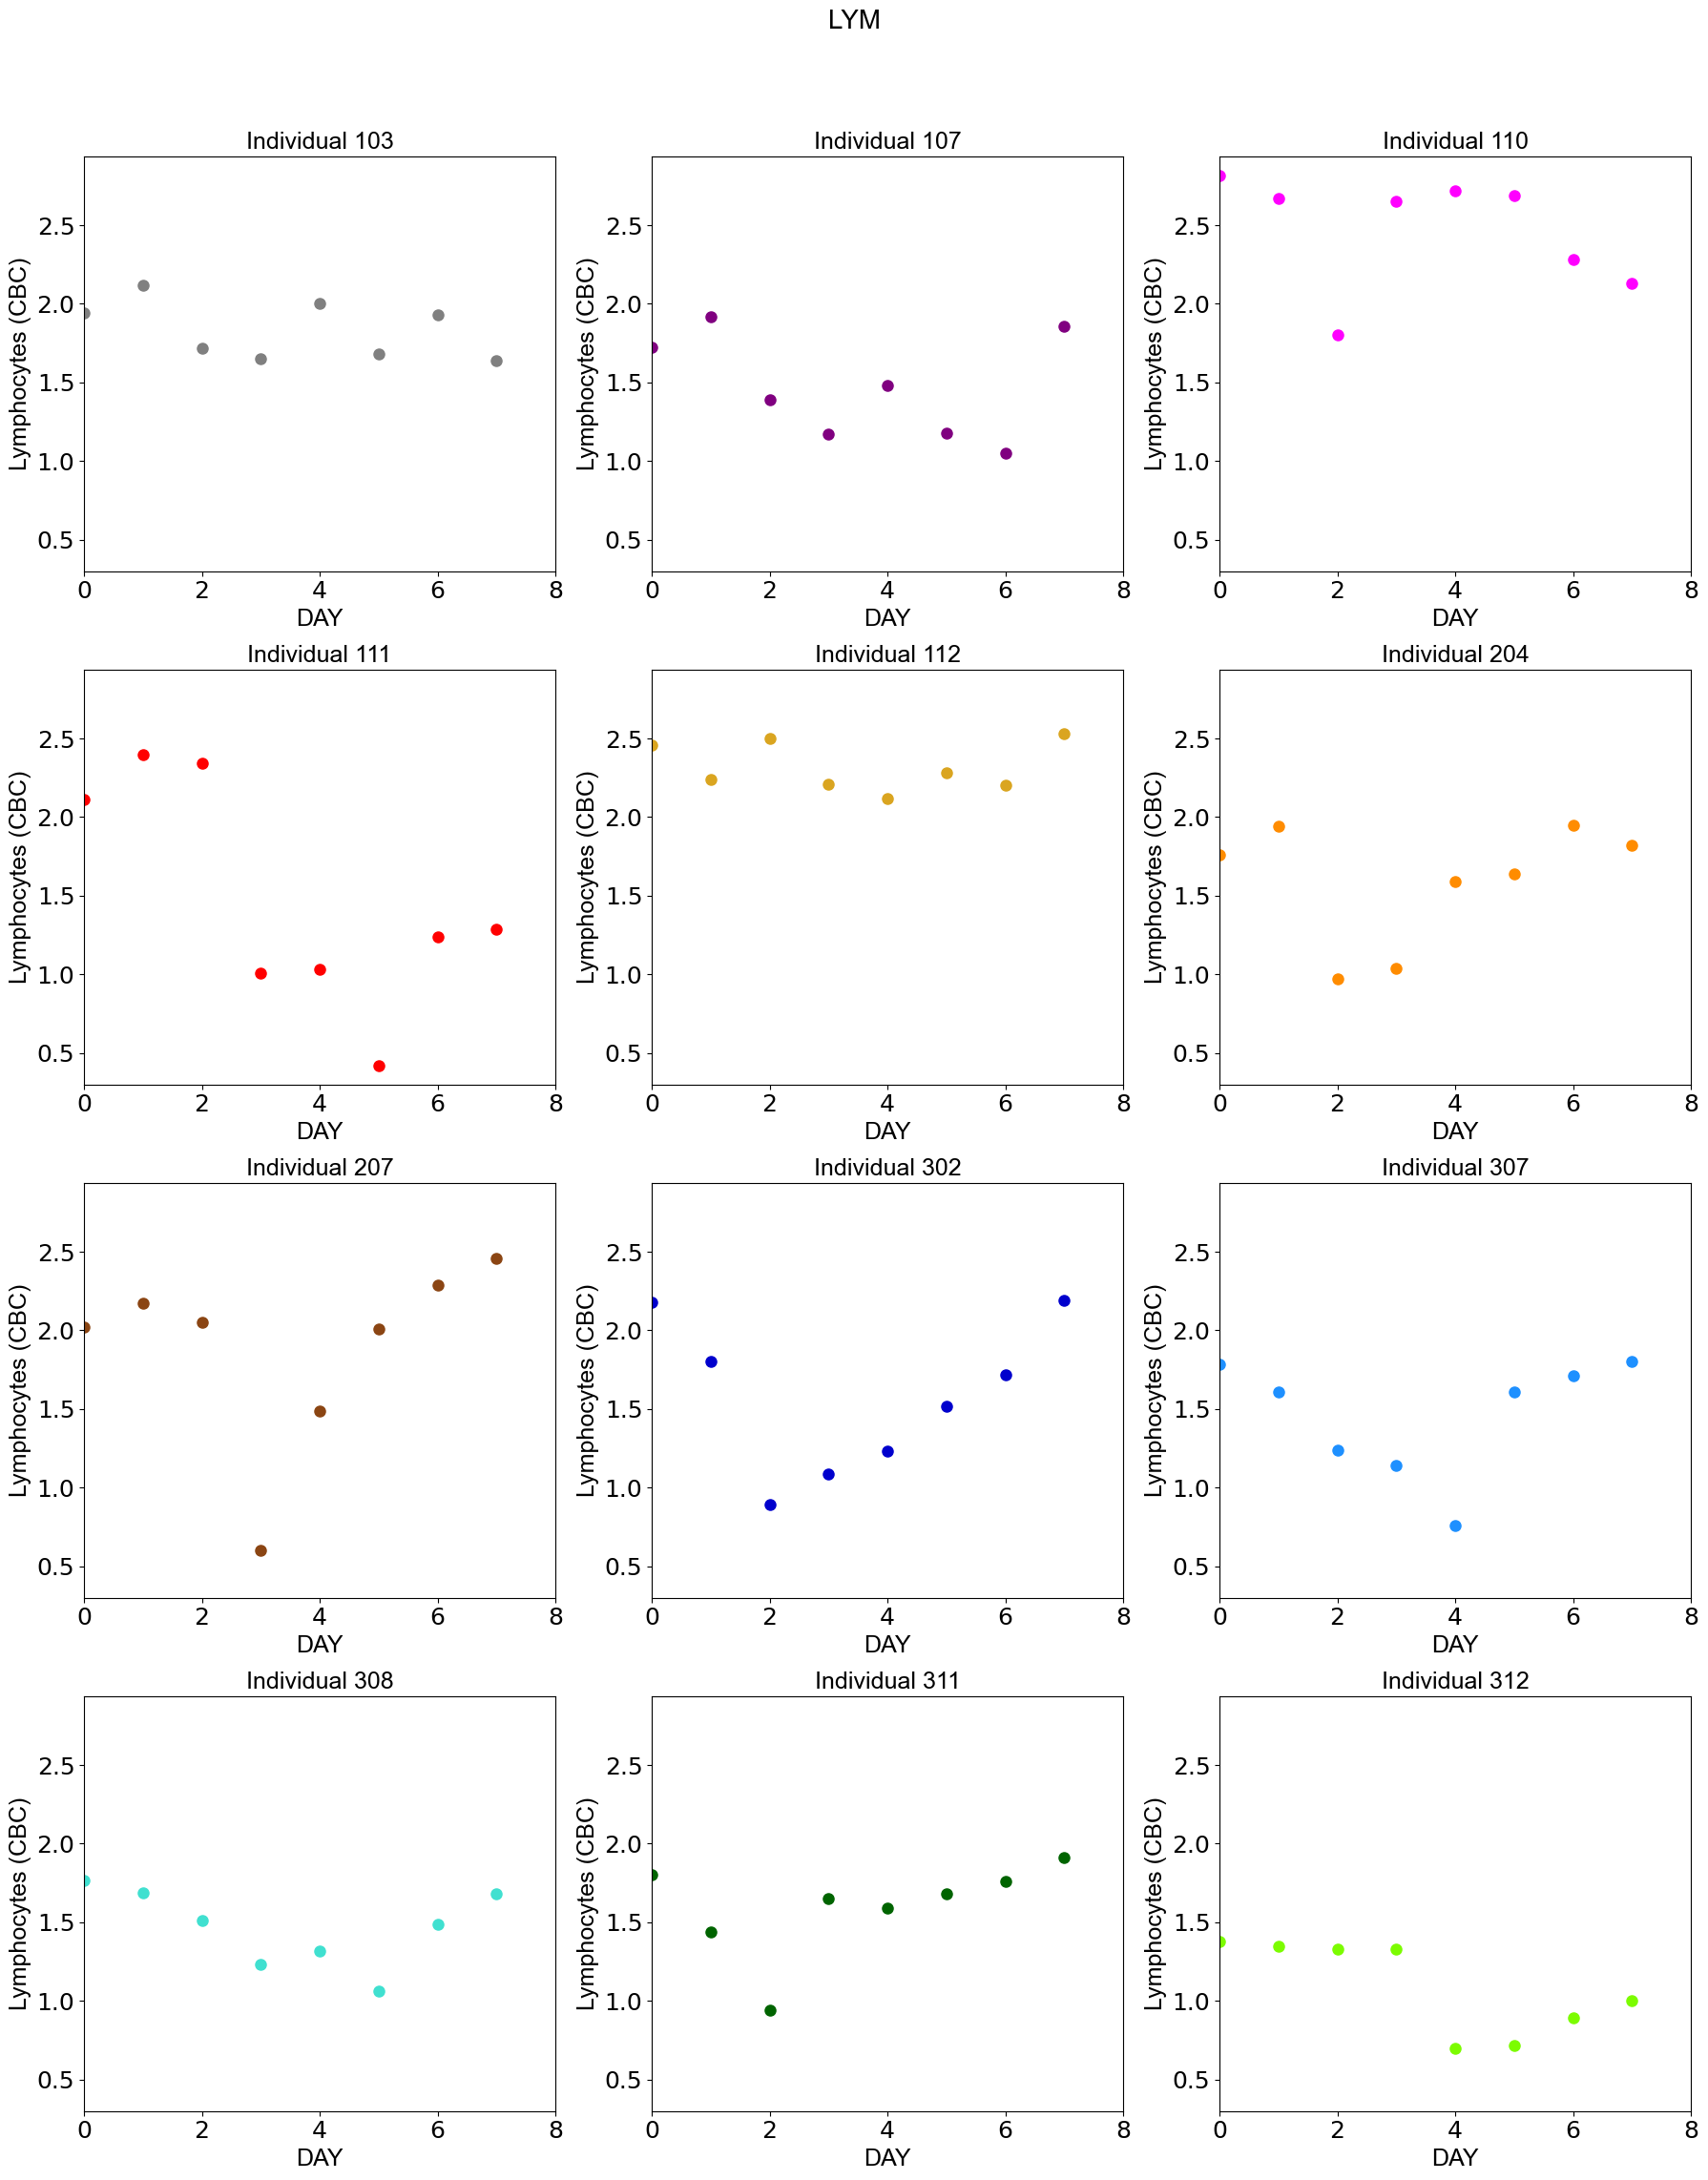

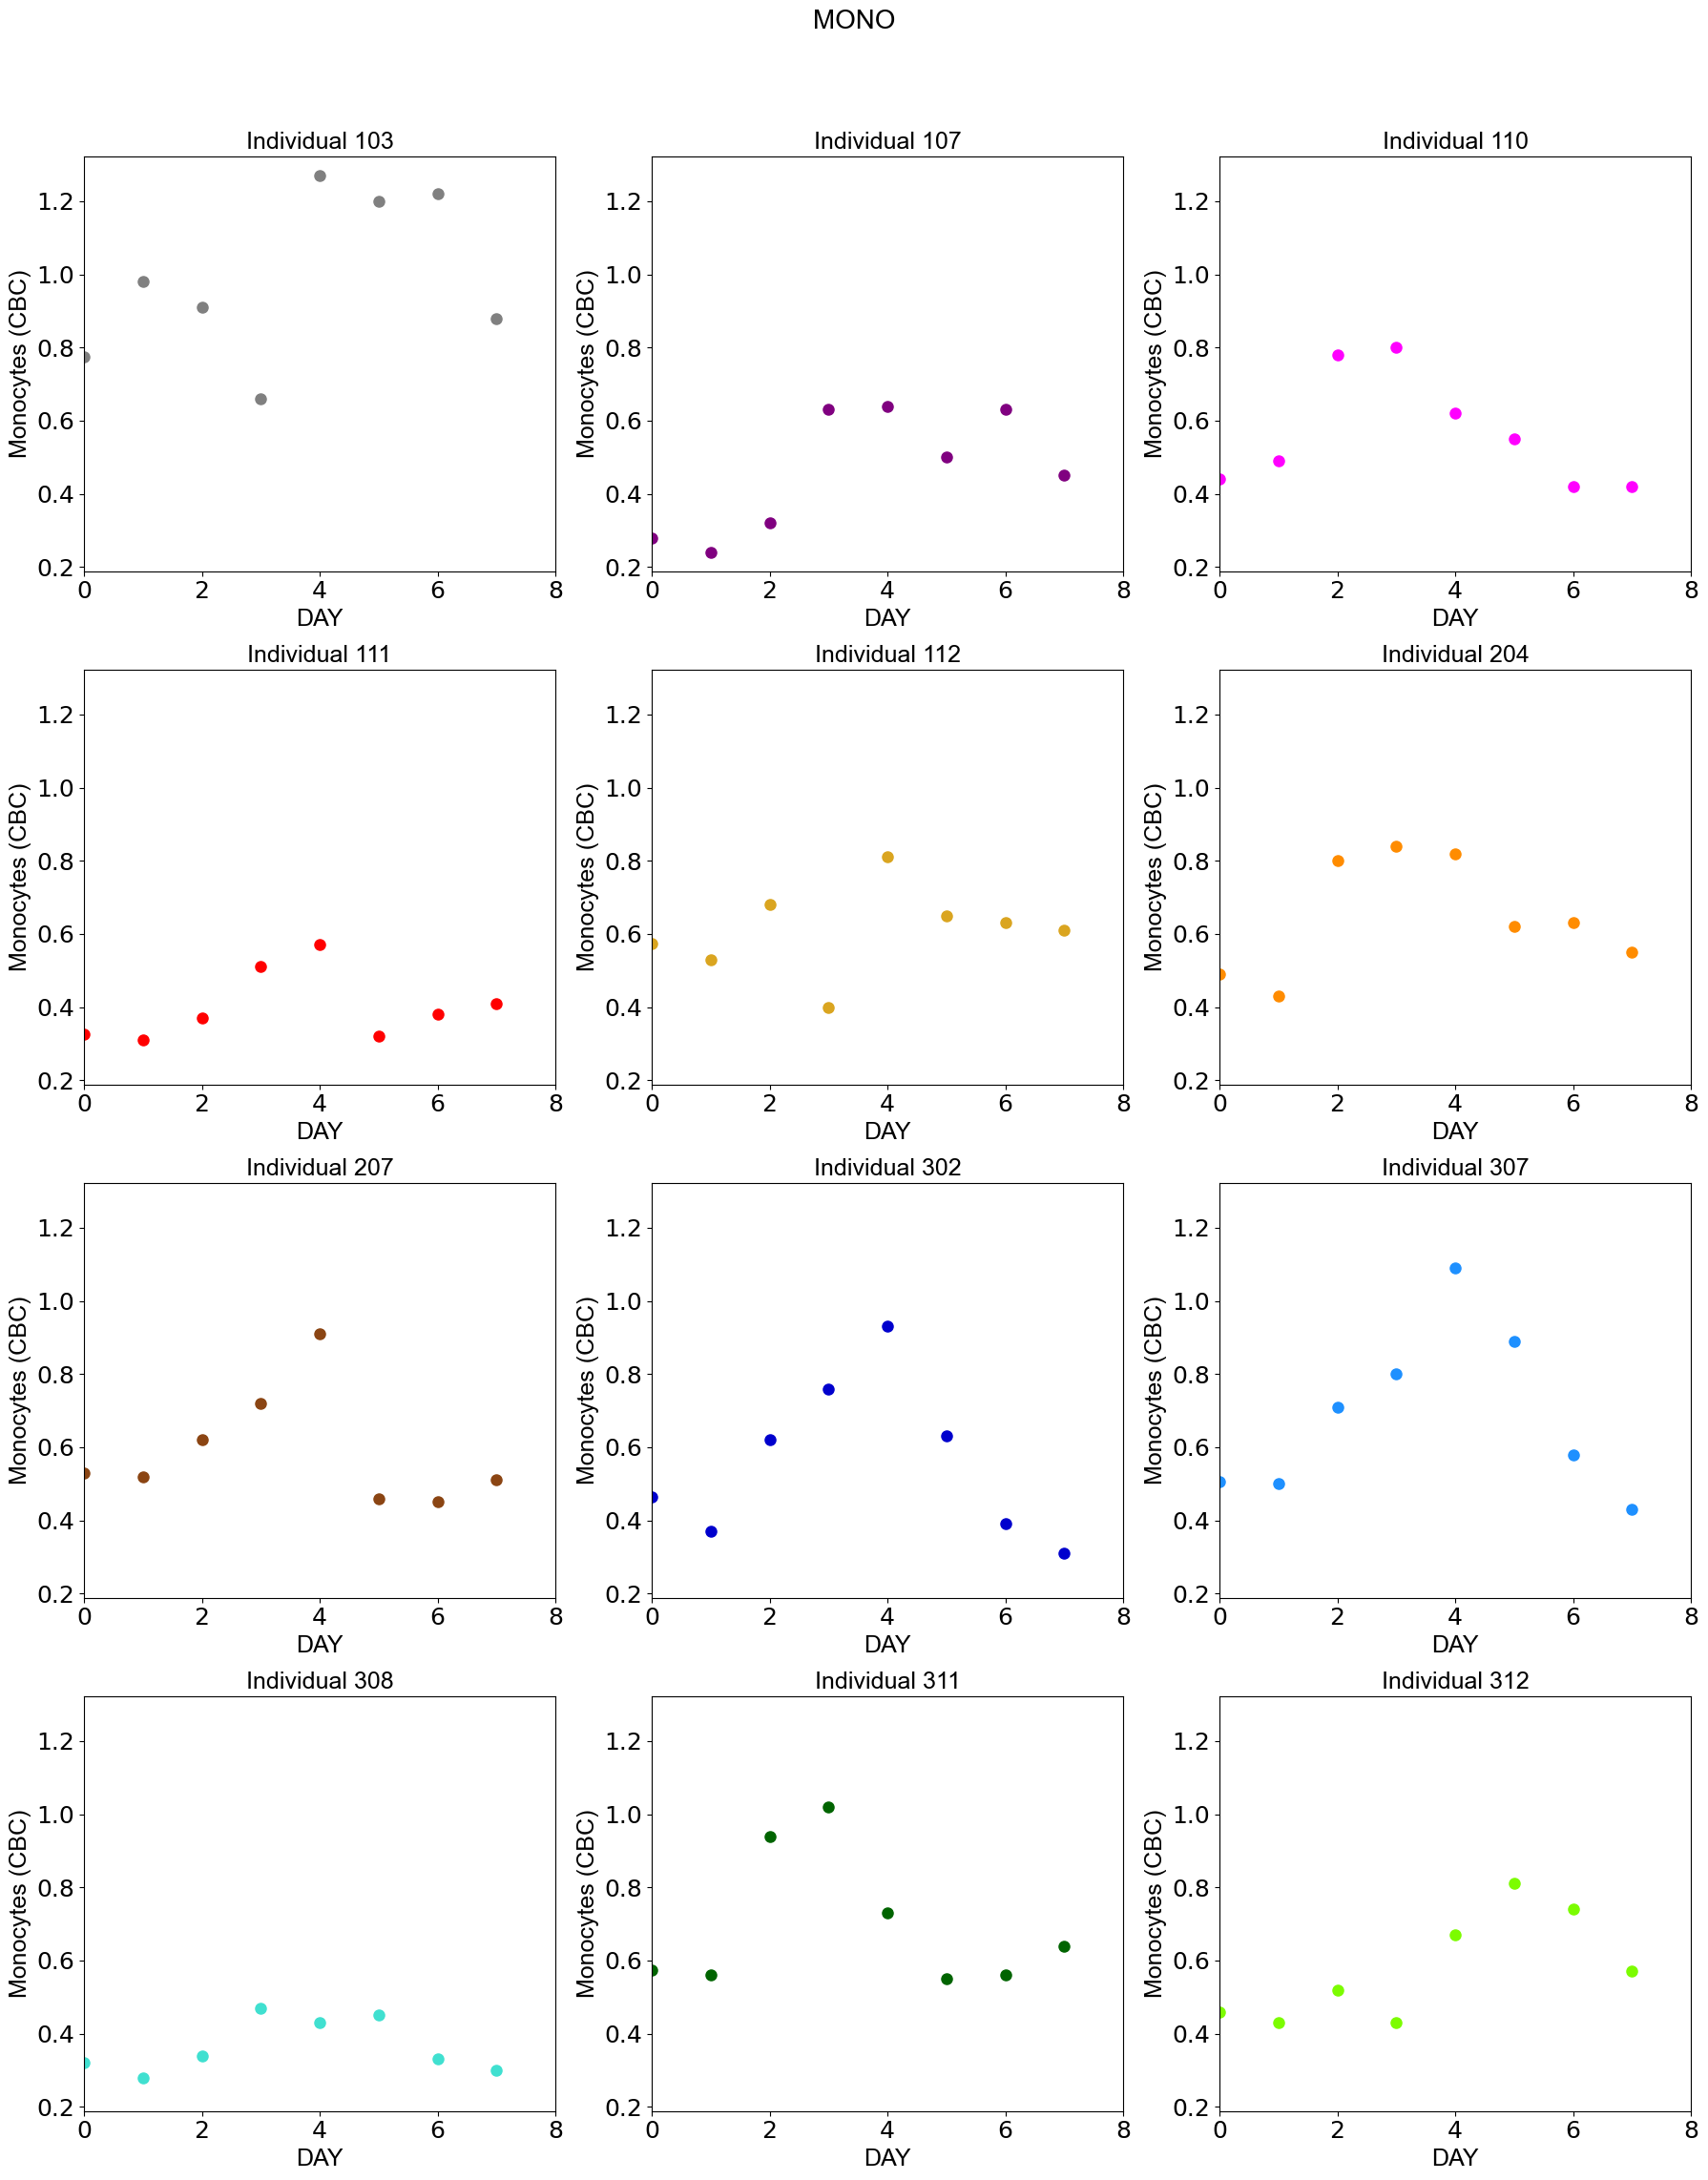

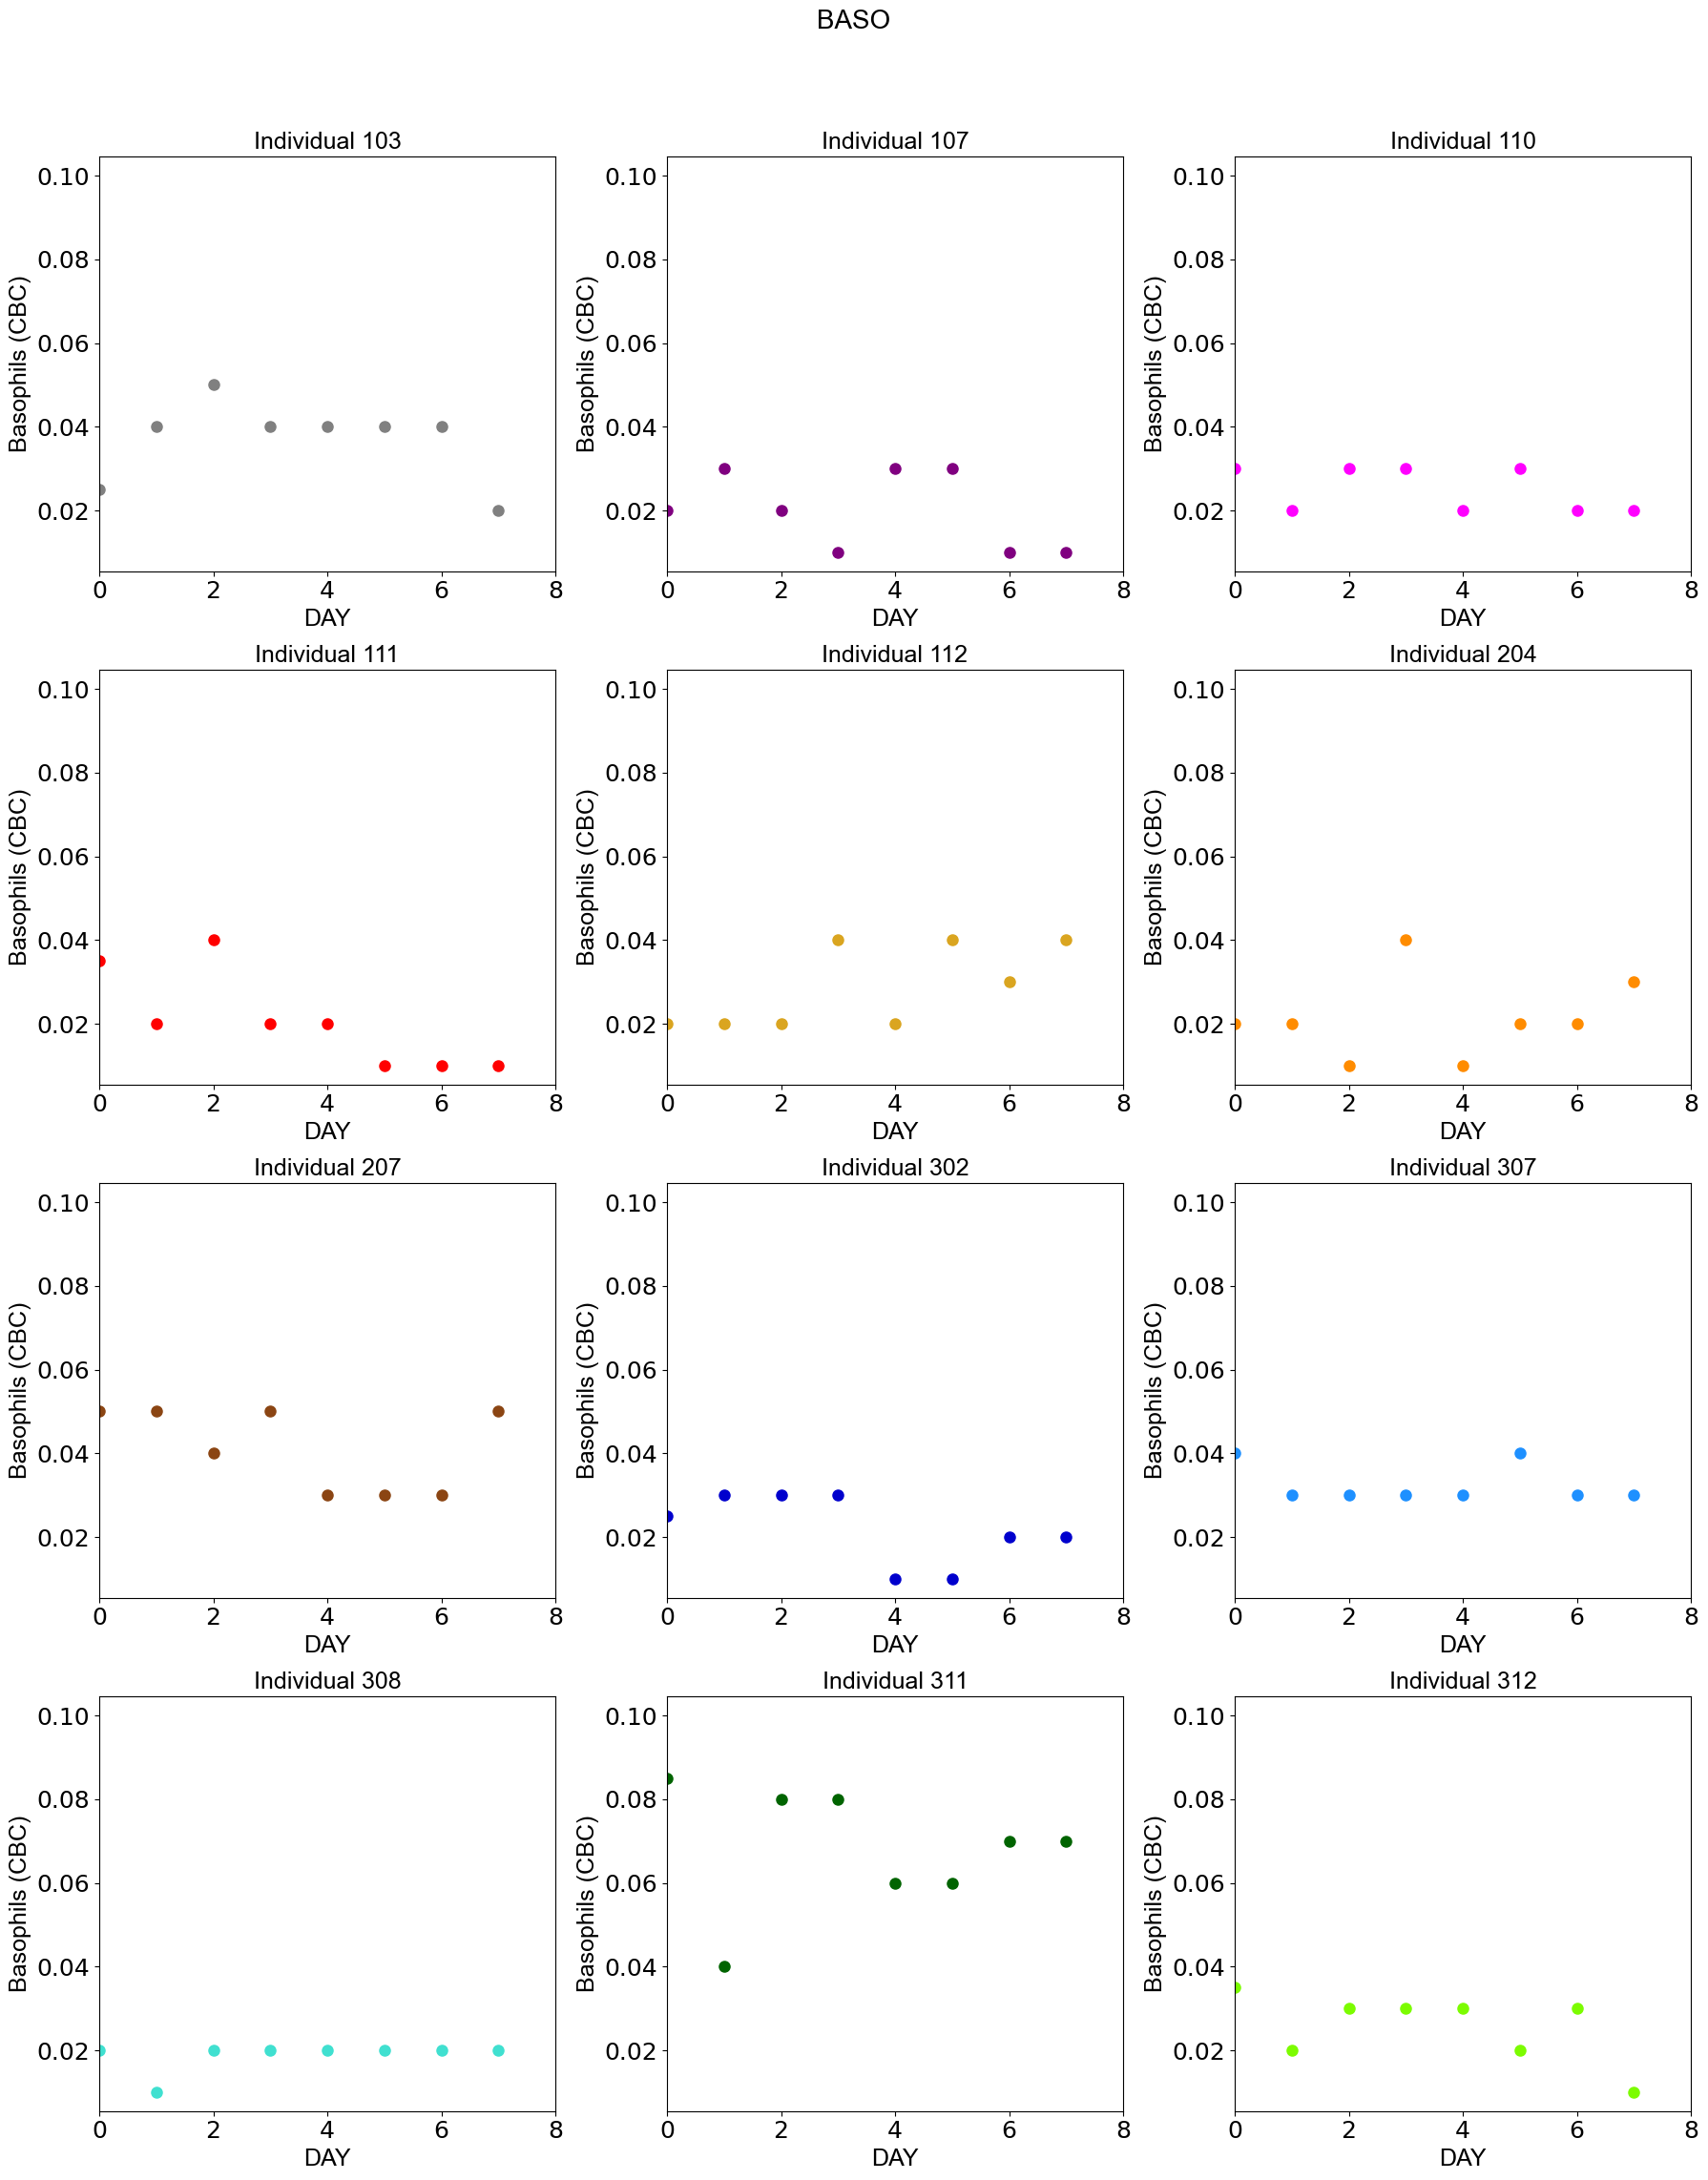

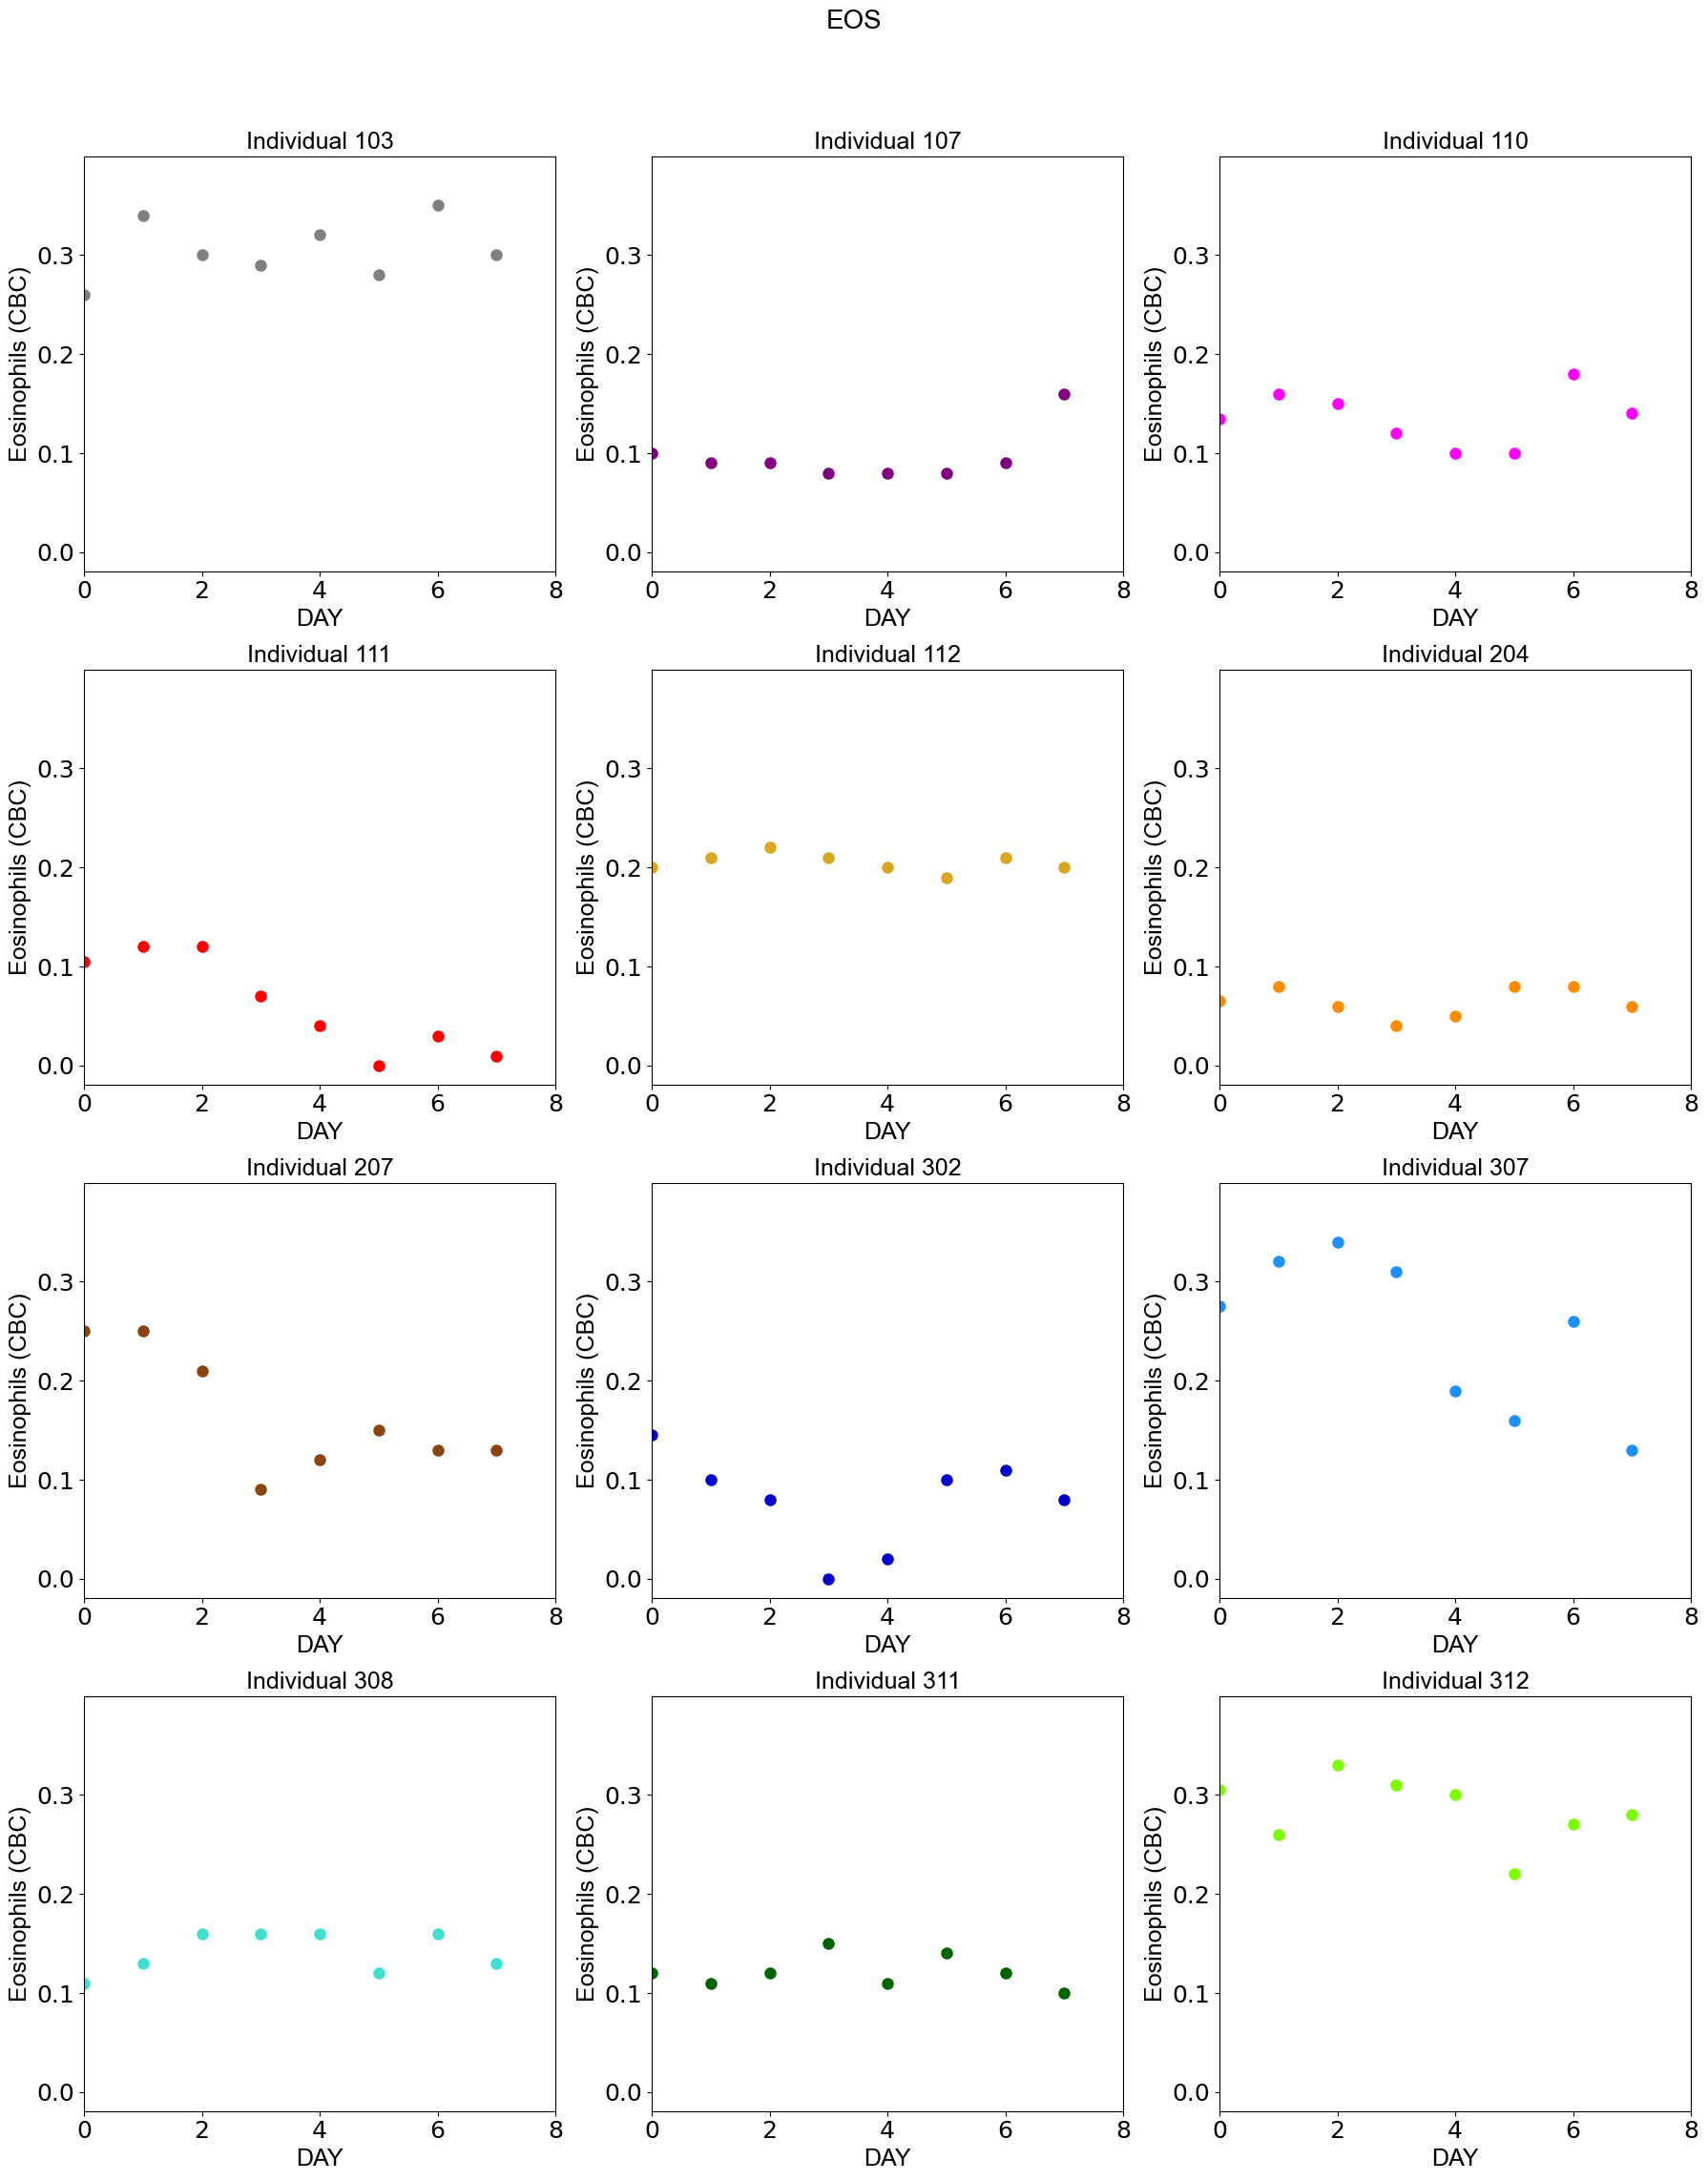

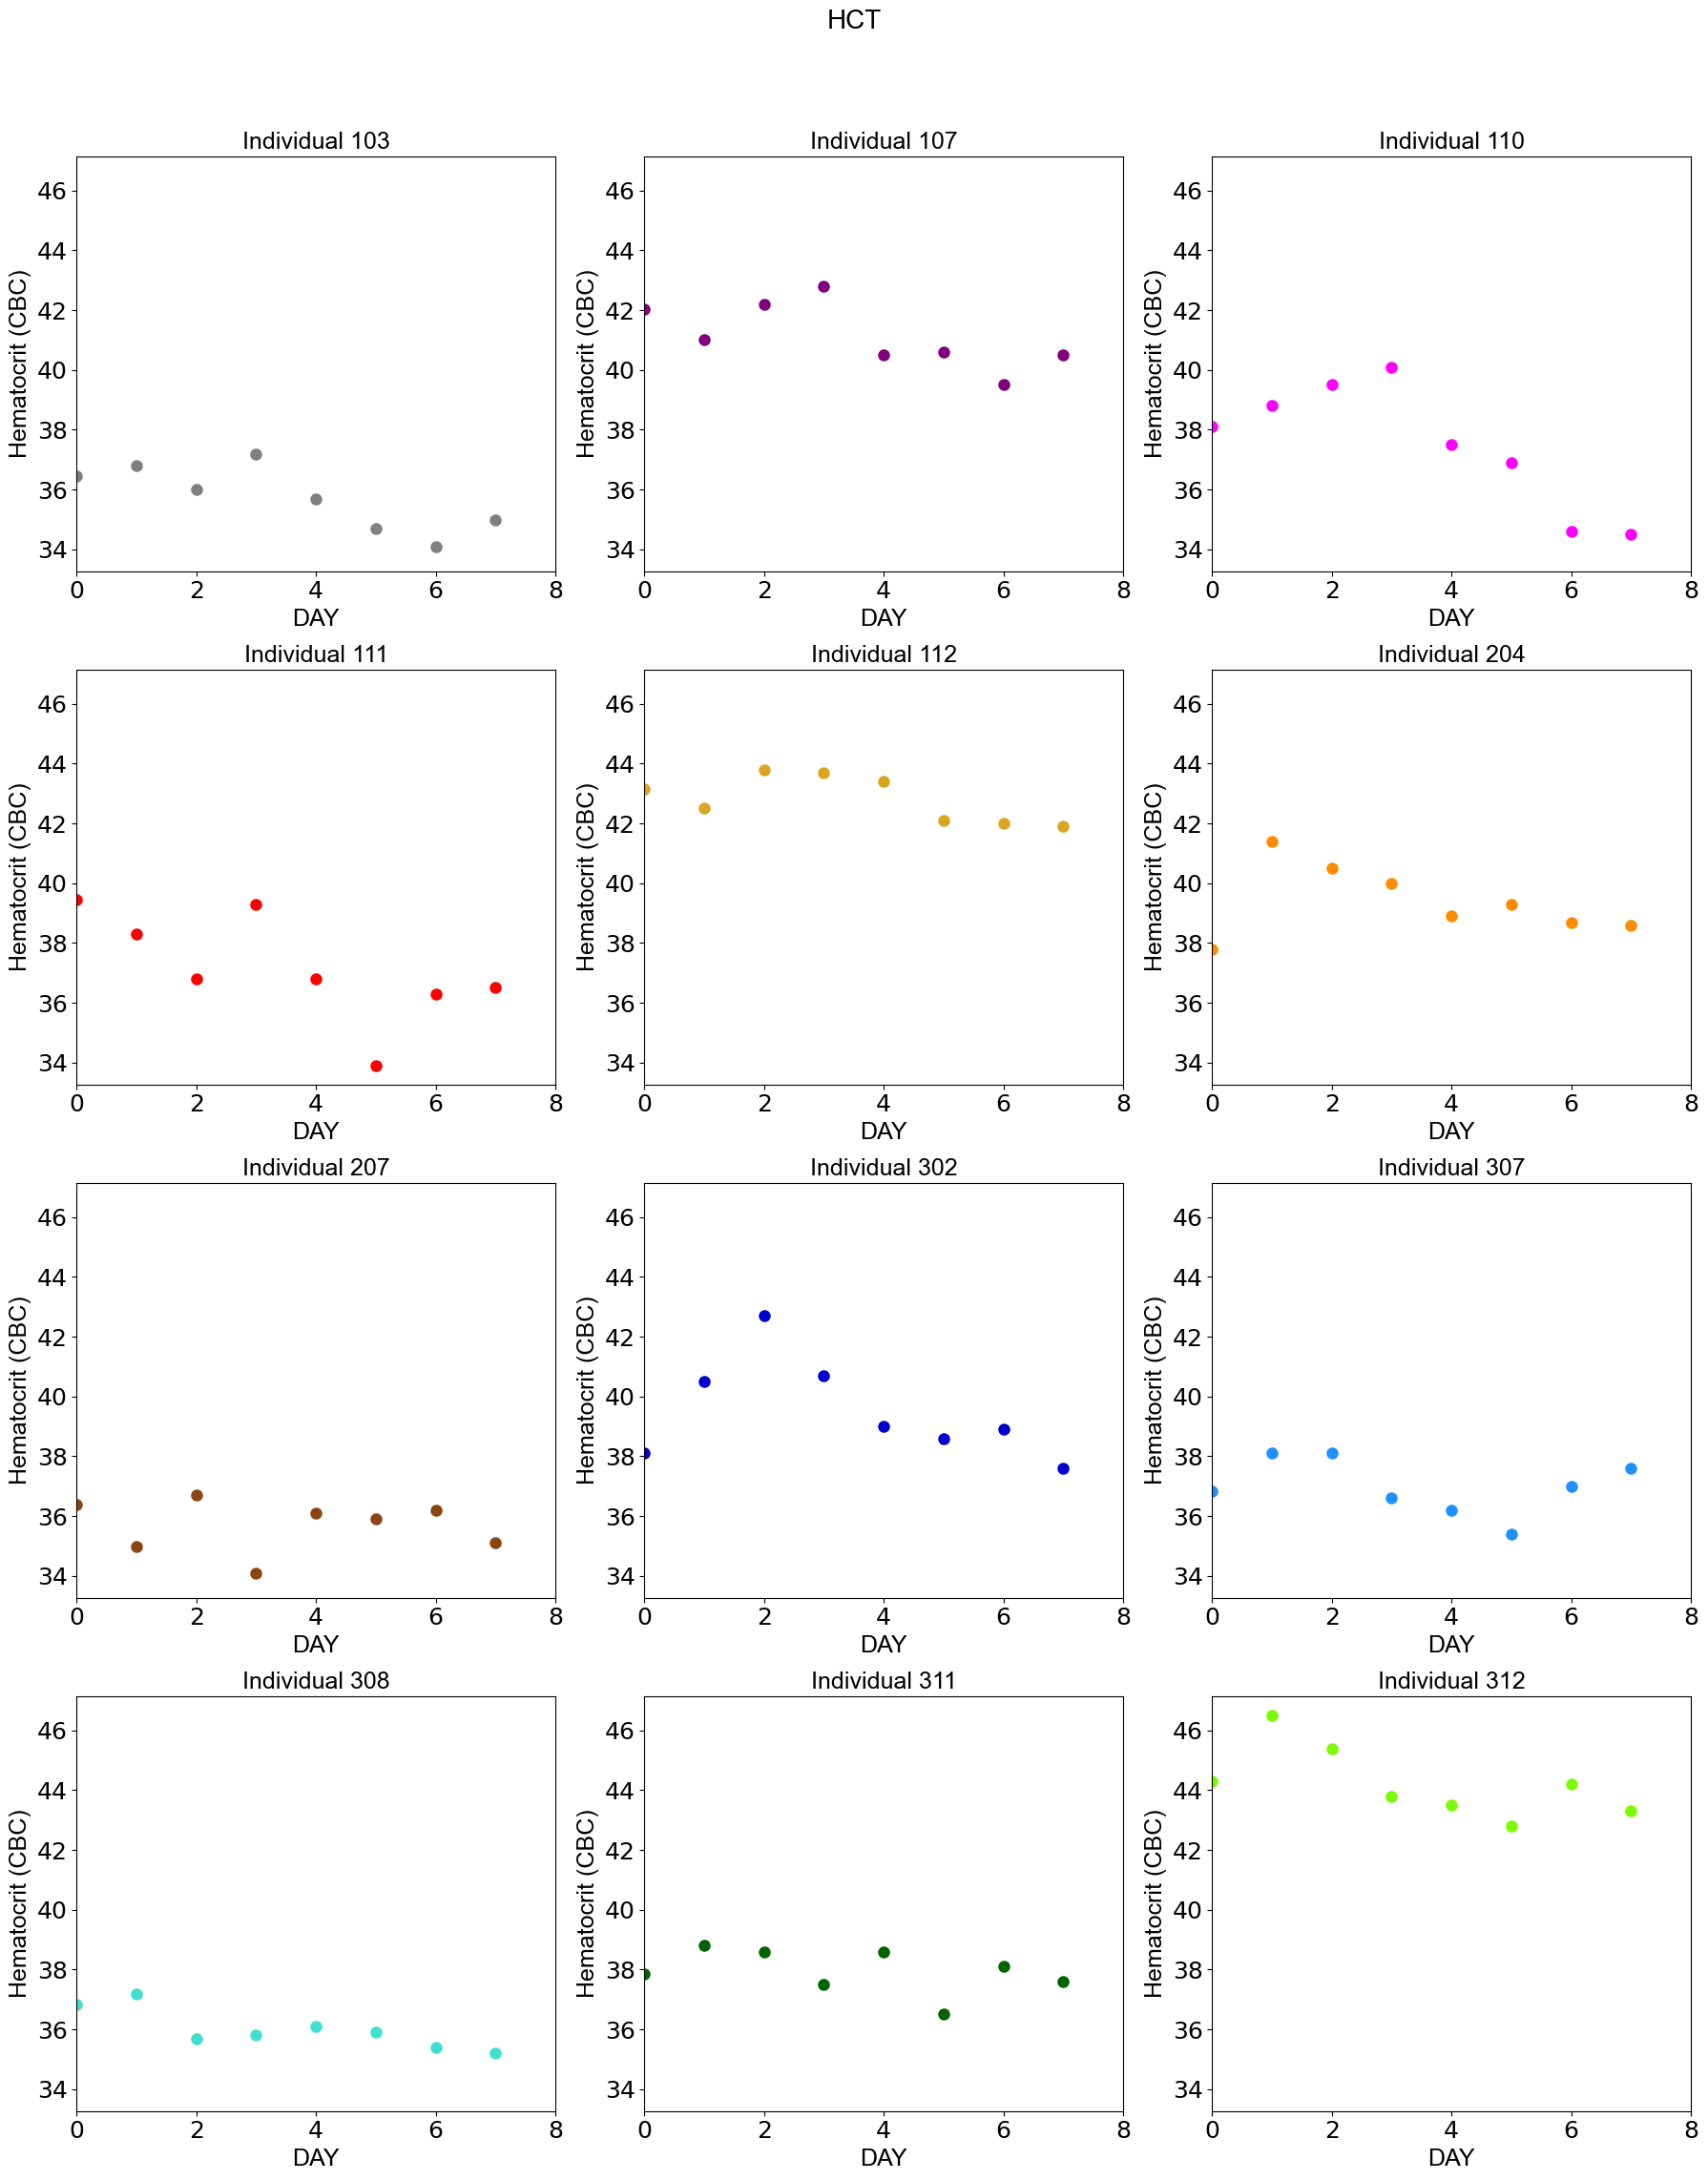

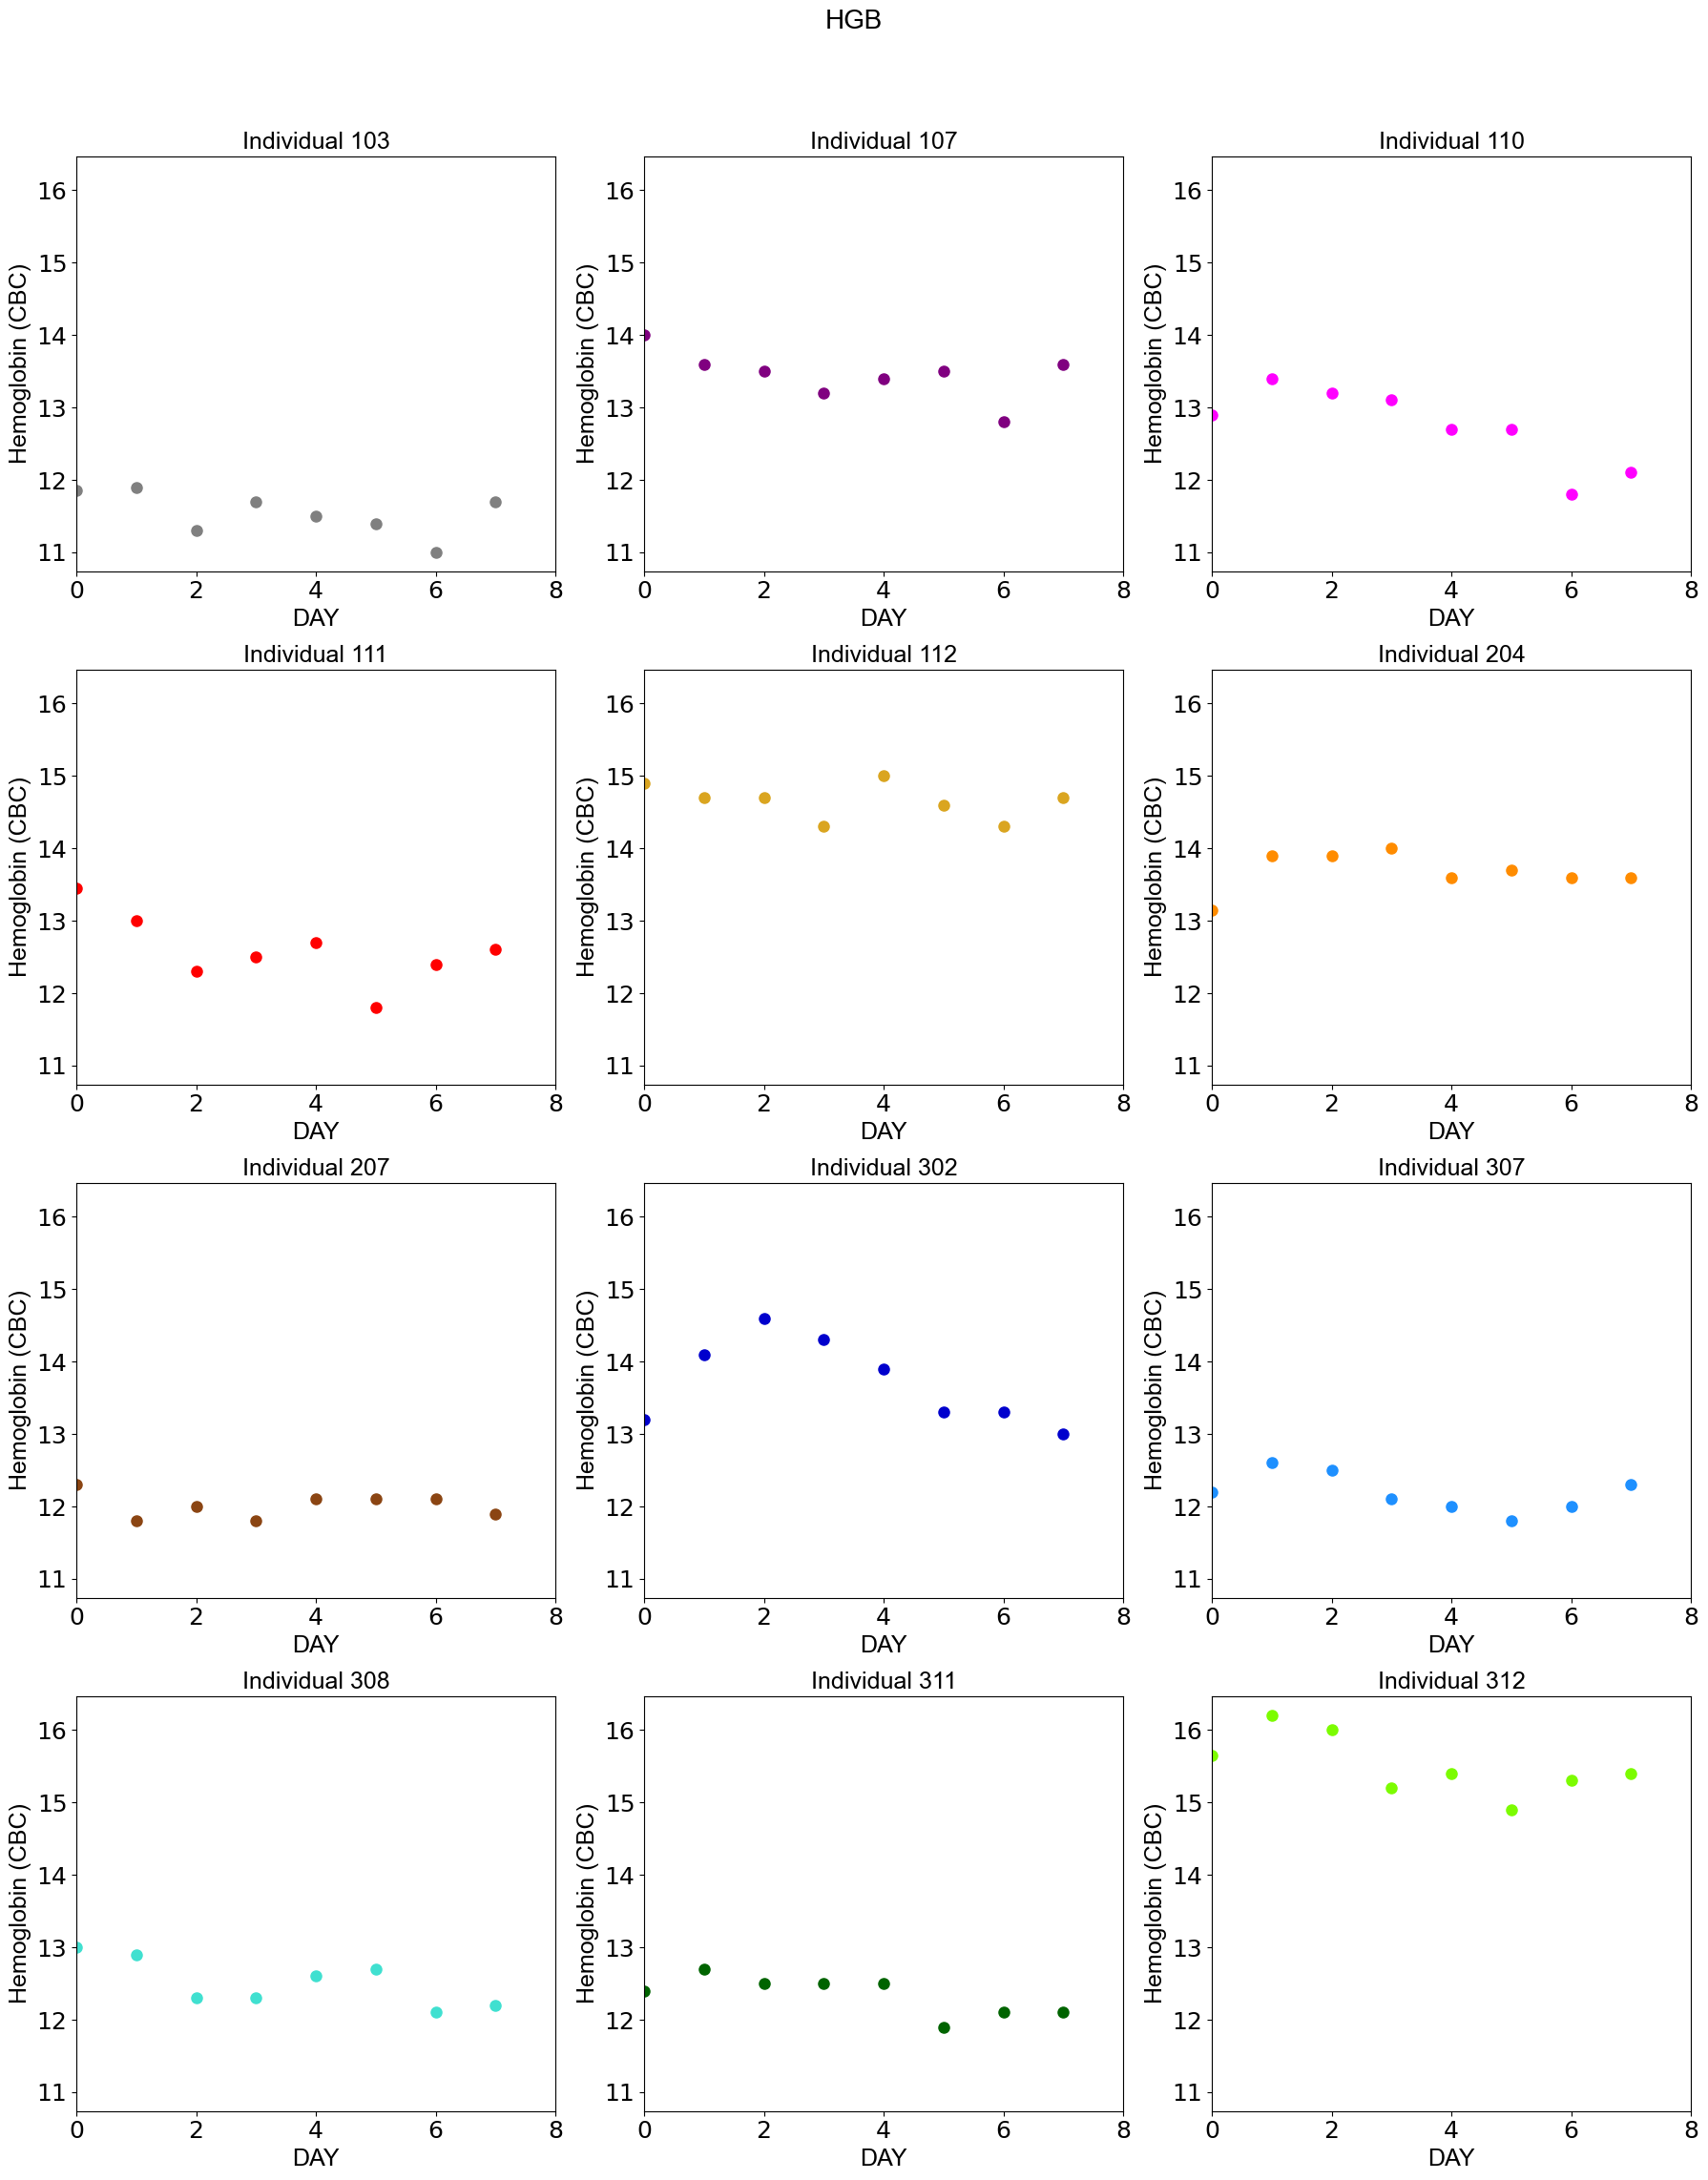

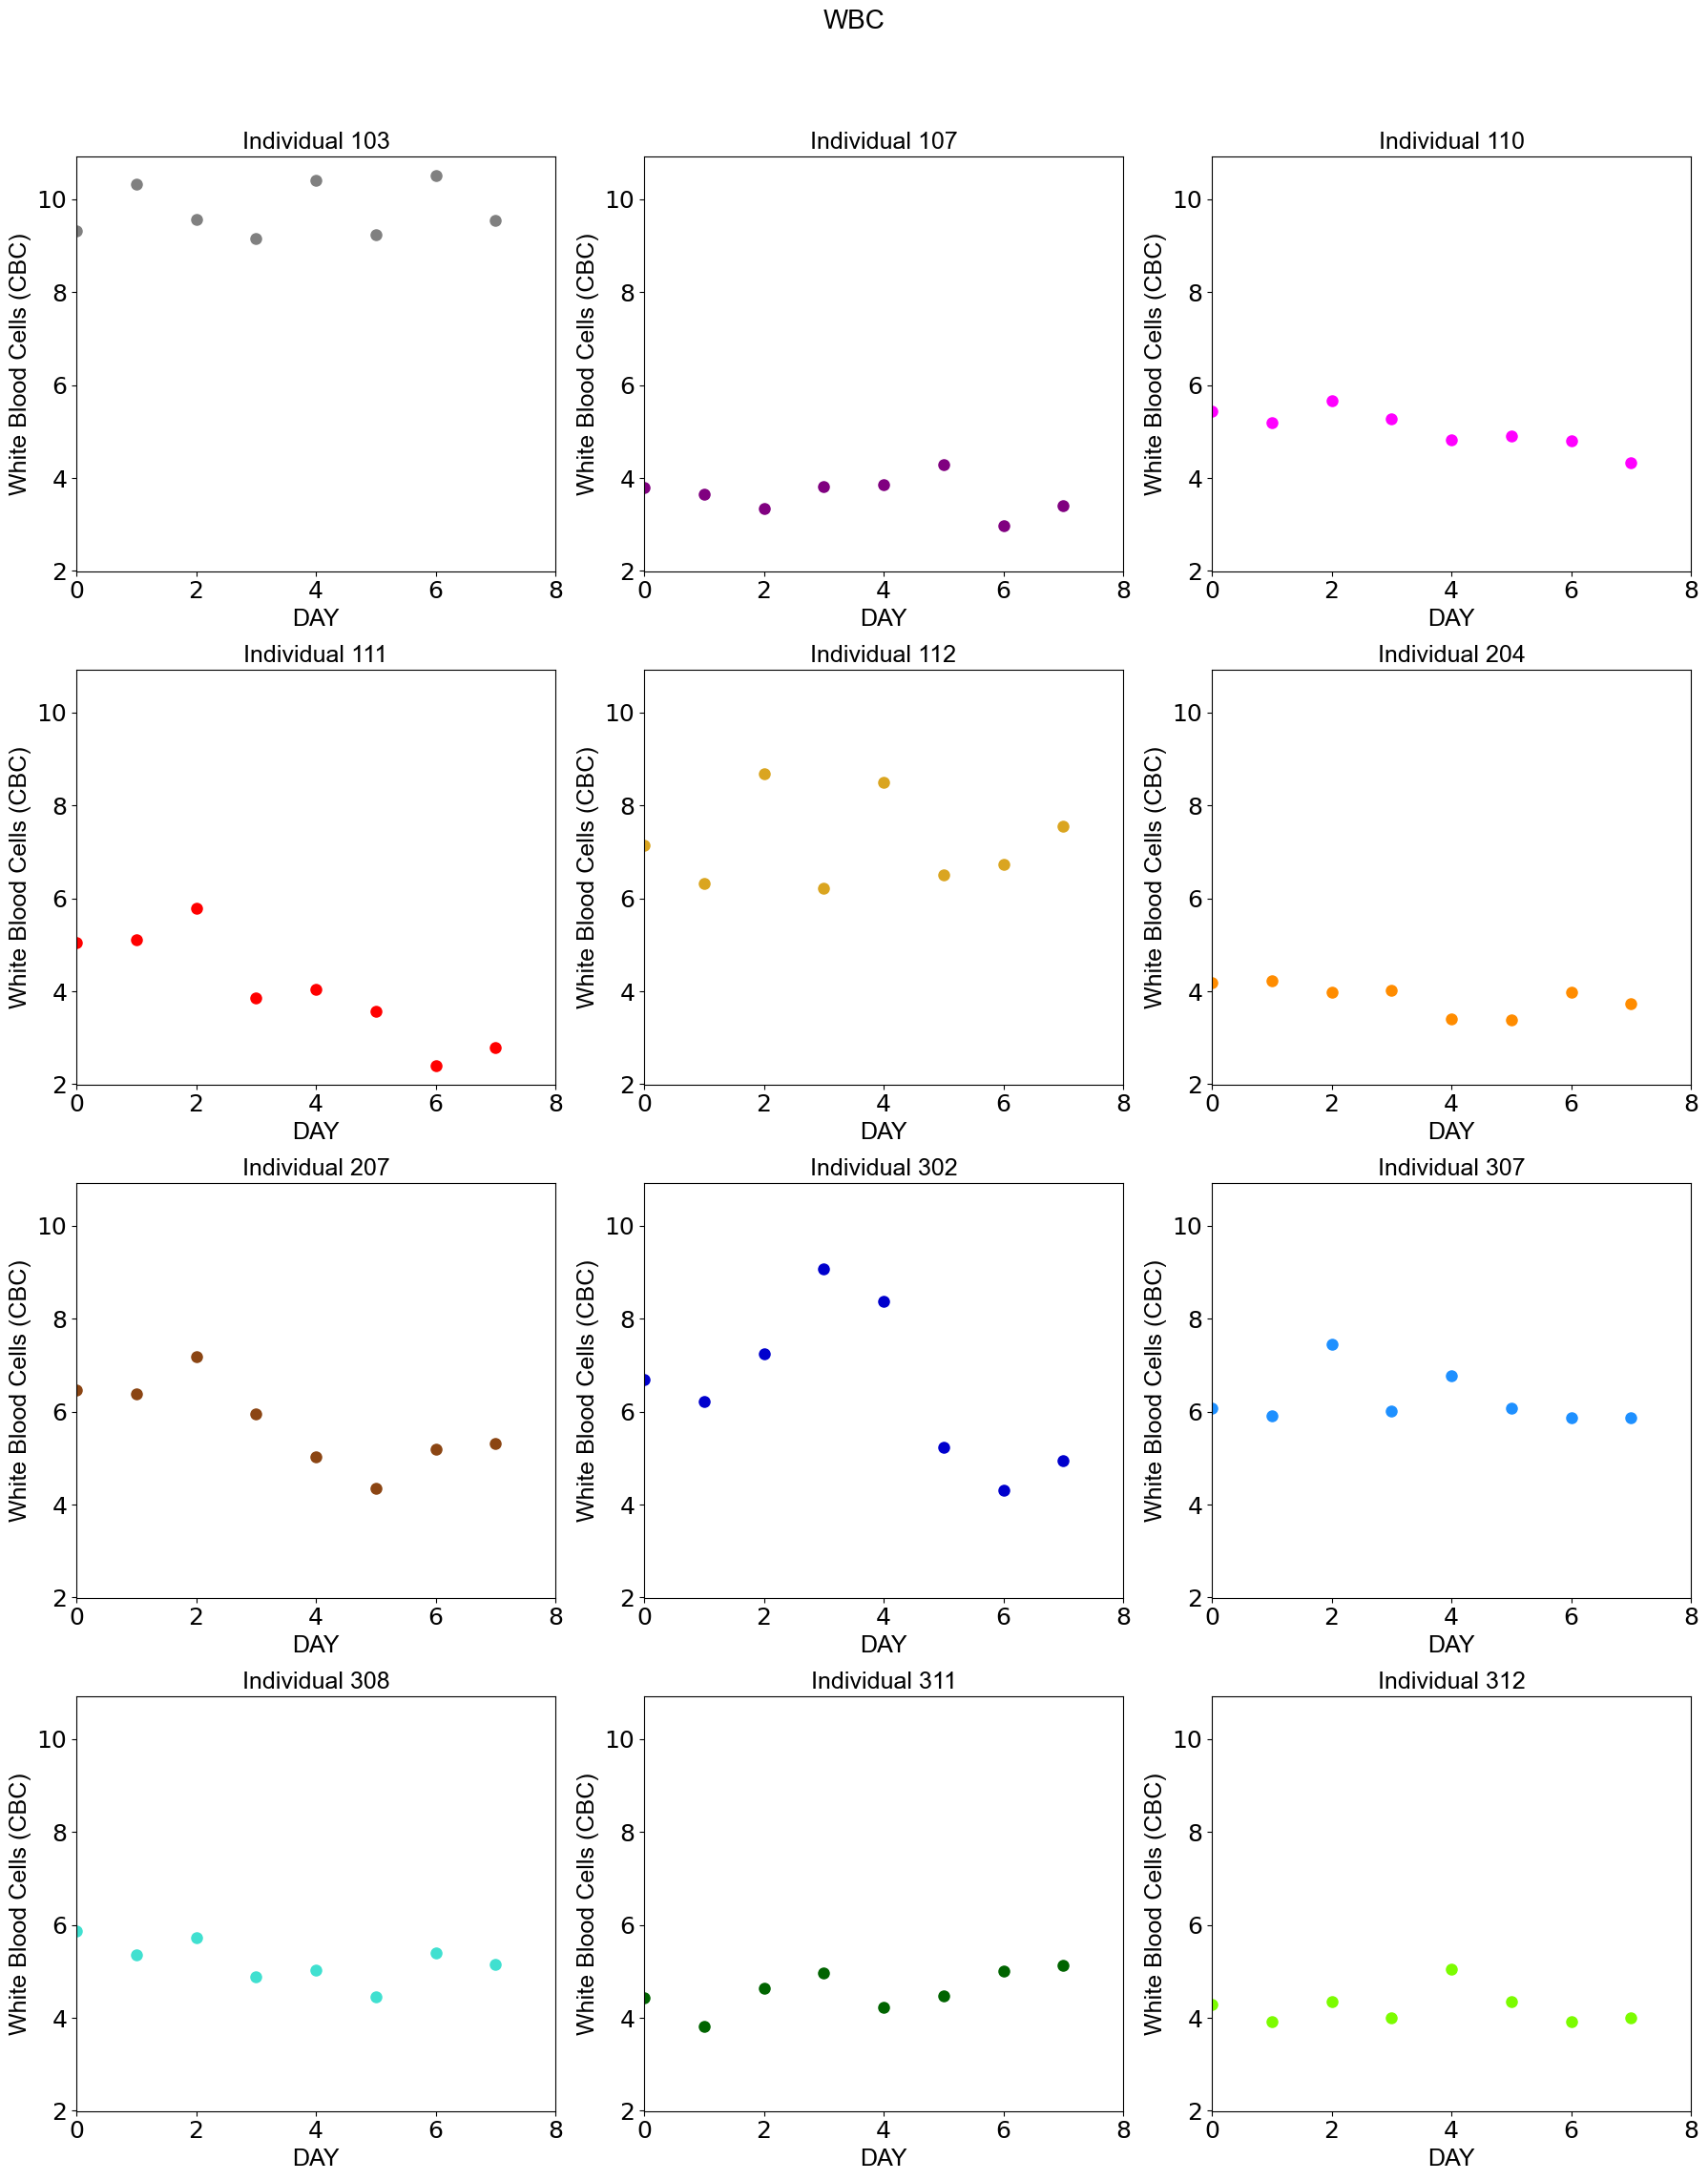

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_cbc_data(filename, log10=False):
    """
    Reads a CBC data sheet (with an extra header in the first row), filters for a fixed set of volunteers,
    and creates a figure for each CBC column (NEUT, PLAT, RBC, LYM, MONO, BASO, EOS, HCT, HGB, WBC).
    
    For each figure:
      - The x-axis is DAY (ranging from 0 to 8).
      - There are 12 subplots arranged in a 3-column x 4-row grid, one per volunteer.
      - Each subplot is labeled "Individual {VOLUNTEER}".
      - All subplots share the same Y-axis limits (computed globally for that measurement).
      - The Y-axis is labeled with the full cell class name and CBC unit.
      - Data are plotted as solid markers (only markers, no connecting line) in a predetermined color order.
      
    Parameters:
        filename (str): Path to the data file (Excel or CSV). The first row is skipped.
        log10 (bool): If True, transform the data via log10 (applied before plotting).
                      (Note: the transformation is done on the data values, not via a log-scale axis.)
    """

    df = pd.read_excel(filename)
    
    # List of volunteers to include and their corresponding colors.
    volunteers = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
    colors = ['gray', 'purple', 'magenta', 'red', 'goldenrod', 'darkorange', 
              'saddlebrown', 'mediumblue', 'dodgerblue', 'turquoise', 'darkgreen', 'lawngreen']
    
    # Define the CBC columns and the full cell class names for y-axis labels.
    cbc_columns = {
        'NEUT': "Neutrophils (CBC)",
        'PLAT': "Platelets (CBC)",
        'RBC':  "Red Blood Cells (CBC)",
        'LYM':  "Lymphocytes (CBC)",
        'MONO': "Monocytes (CBC)",
        'BASO': "Basophils (CBC)",
        'EOS':  "Eosinophils (CBC)",
        'HCT':  "Hematocrit (CBC)",
        'HGB':  "Hemoglobin (CBC)",
        'WBC':  "White Blood Cells (CBC)"
    }
    
    # Organize the data by volunteer.
    volunteer_data = {}
    for vol in volunteers:
        volunteer_data[vol] = df[df['VOLUNTEER'] == vol]
        if volunteer_data[vol].empty:
            print(f"Warning: No data found for volunteer {vol}.")

    # Loop through each CBC measurement column.
    for col, ylabel in cbc_columns.items():
        # Collect all values (transformed if needed) across volunteers to determine global y-axis limits.
        all_vals = []
        for vol in volunteers:
            series = volunteer_data[vol][col]
            # Apply log10 transformation if flag is True; mask non-positive values to avoid errors.
            if log10:
                series = series.where(series > 0)  # non-positive become NaN
                series = np.log10(series)
            all_vals.append(series)
        # Concatenate series from all volunteers and compute global min and max (ignoring NaNs).
        global_vals = pd.concat(all_vals)
        y_min, y_max = global_vals.min(), global_vals.max()
        # Add a margin (if the range is non-zero).
        if pd.notnull(y_min) and pd.notnull(y_max) and (y_max - y_min) > 0:
            margin = 0.05 * (y_max - y_min)
        else:
            margin = 1
        y_min -= margin
        y_max += margin
        
        # Create a figure with 12 subplots arranged in 3 columns and 4 rows.
        fig, axs = plt.subplots(4, 3, figsize=(18, 24))
        axs = axs.flatten()  # flatten to a 1D list for easier iteration
        
        # Plot each volunteer's data in its respective subplot.
        for i, vol in enumerate(volunteers):
            ax = axs[i]
            sub_df = volunteer_data[vol]
            # Extract DAY and the current measurement data.
            x = sub_df['DAY']
            y = sub_df[col]
            if log10:
                y = np.where(y > 0, np.log10(y), np.nan)
            # Plot as solid markers (no connecting line).
            ax.plot(x, y, marker='o', linestyle='None', color=colors[i], markersize=8)
            
            # Format subplot labels and limits.
            ax.set_title(f"Individual {vol}", fontname='Arial', fontsize=18)
            ax.set_xlim(0, 8)
            ax.set_ylim(y_min, y_max)
            ax.set_xlabel("DAY", fontname='Arial', fontsize=18)
            ax.set_ylabel(ylabel, fontname='Arial', fontsize=18)
            ax.tick_params(axis='both', labelsize=18)
        
        # In case there are extra subplots (shouldn't occur with exactly 12 volunteers).
        for j in range(len(volunteers), len(axs)):
            axs[j].axis('off')
        
        fig.suptitle(f"{col}", fontname='Arial', fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

plot_cbc_data("../data/Rahil2020_Table8.xlsx", log10=False)


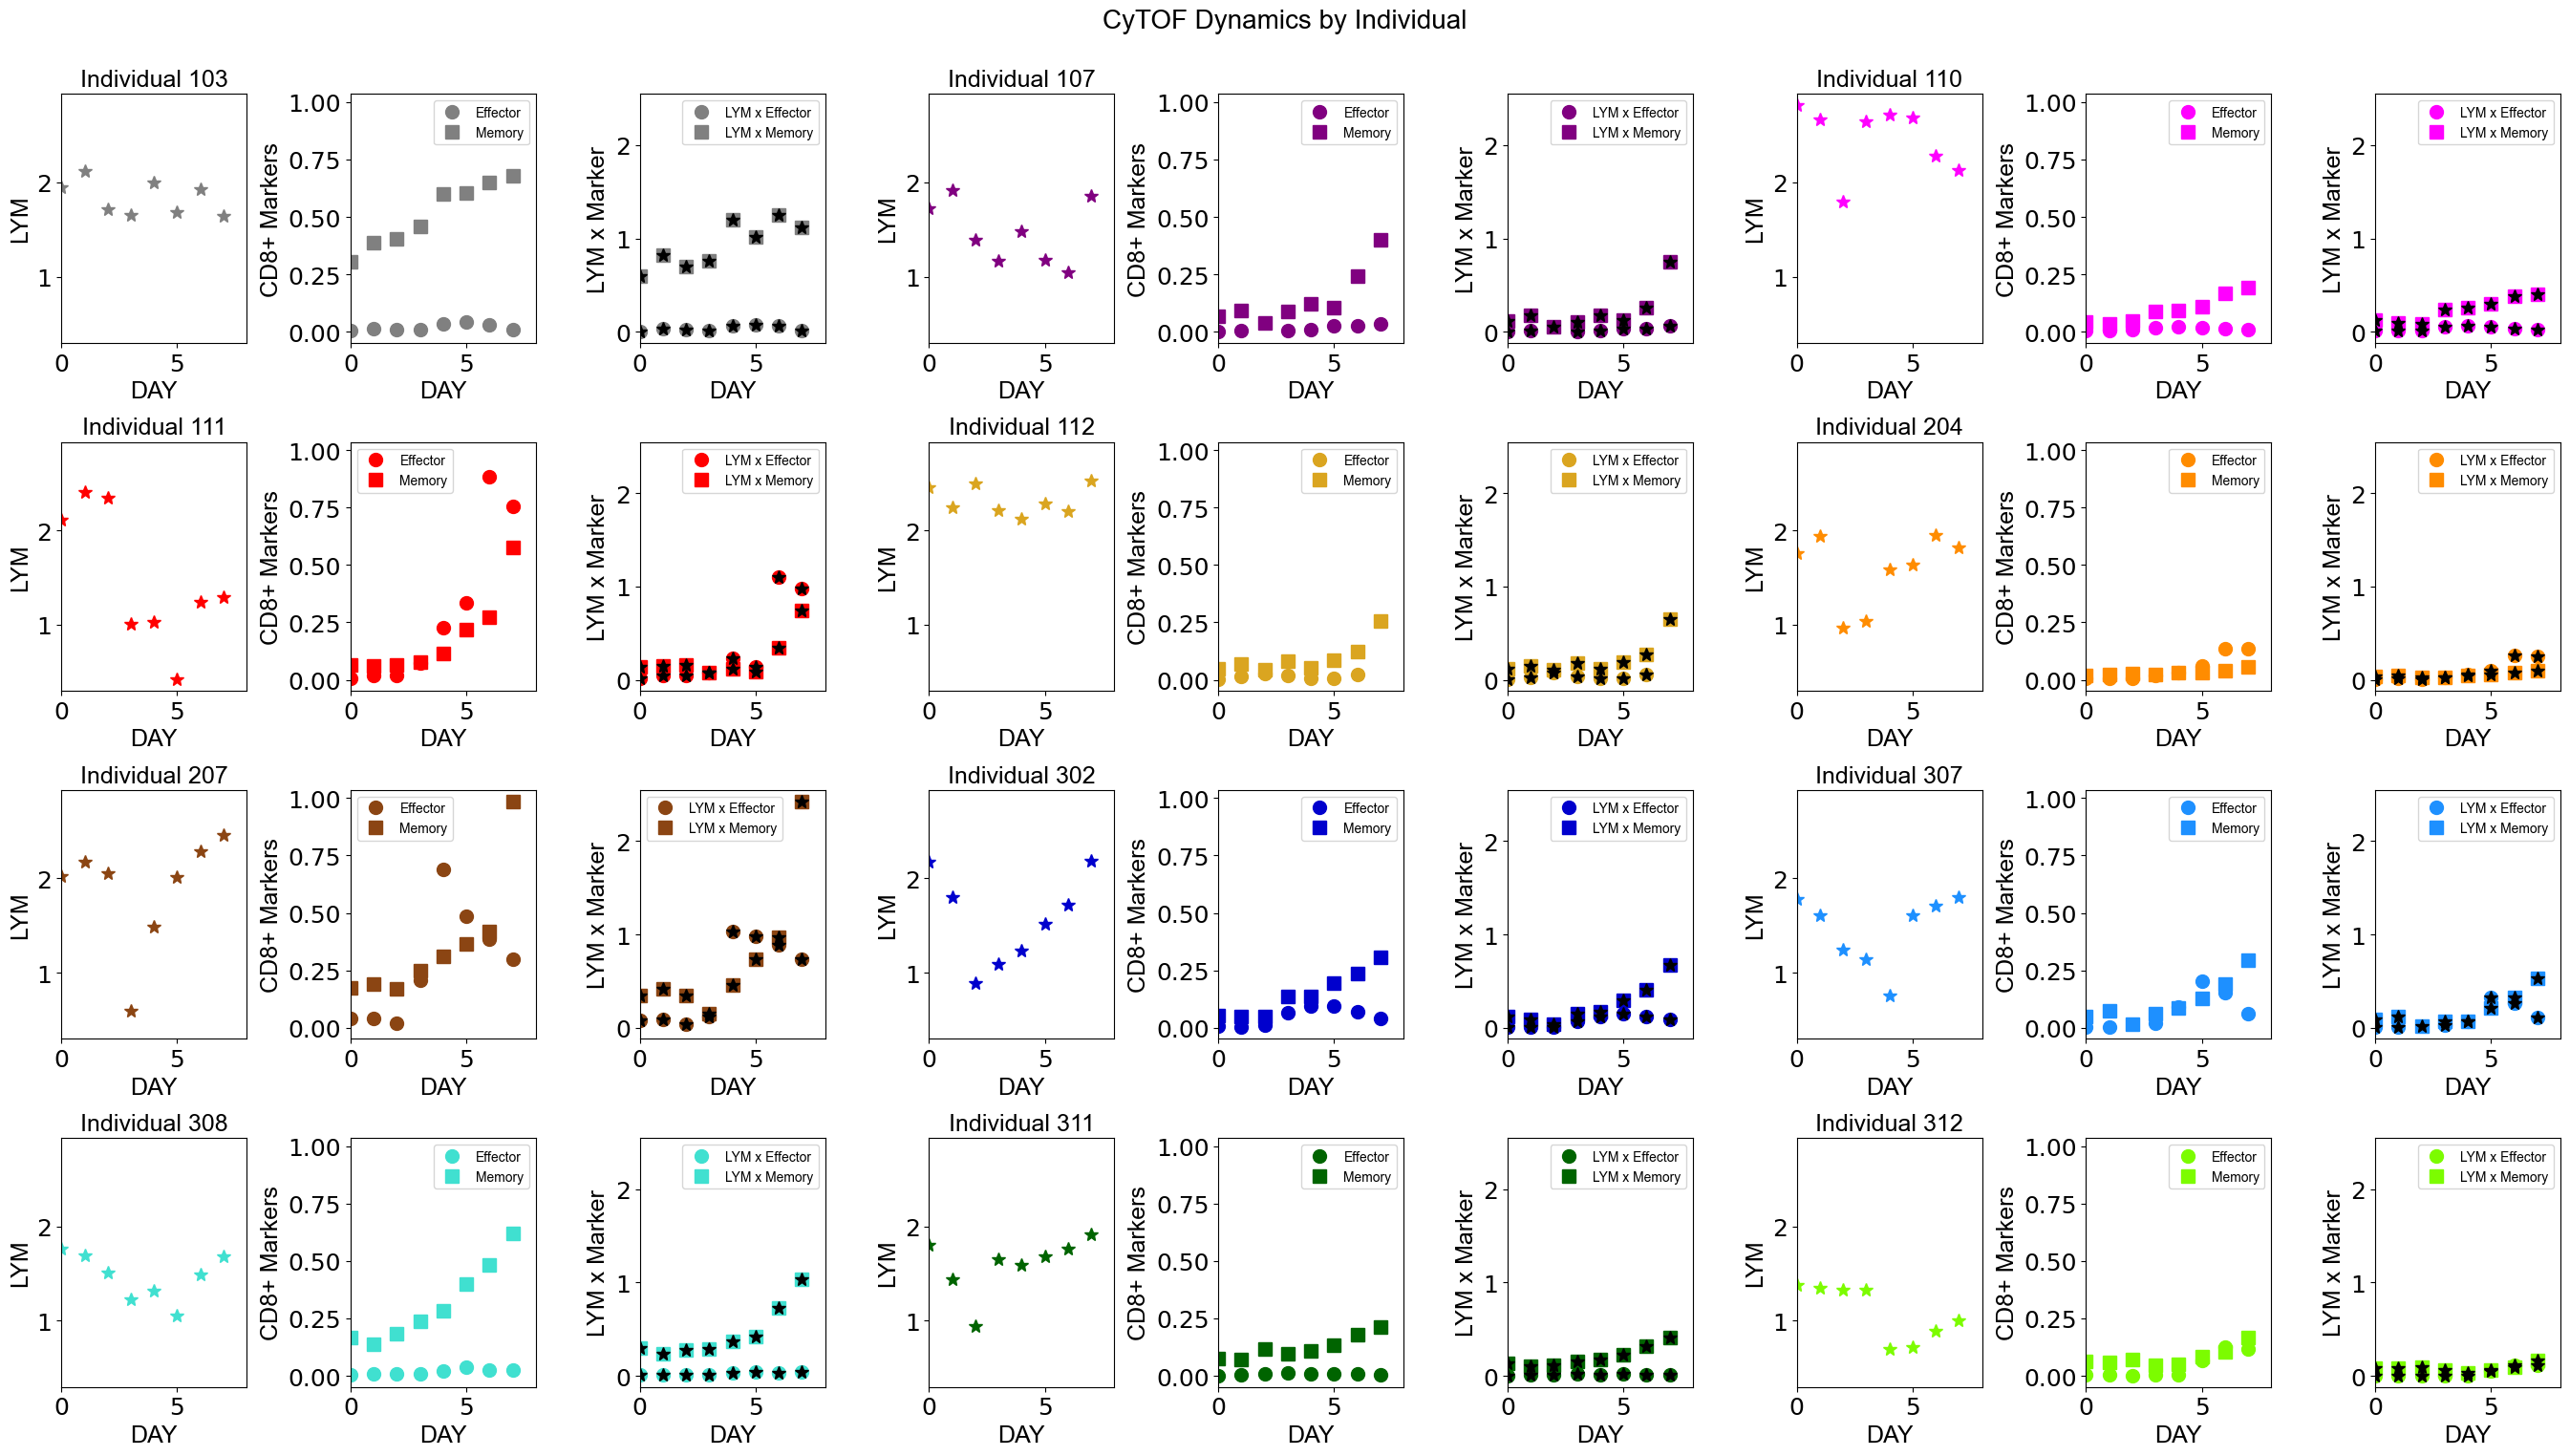

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_cytof_dynamics(filename, log10=False):
    """
    Reads a CyTOF data sheet (skipping an extra header in the first row) and, for a fixed set of volunteers,
    creates one figure that displays three subplots per individual arranged in a 3-column by 4-row grid of groups
    (i.e. overall 9 columns x 4 rows of subplots). For each volunteer the three panels are:
    
      1. LYM vs. DAY, with star markers.
      2. Tcells.CD8+.Effector.CD38+ (circle markers) and Tcells.CD8+.Memory.CD38+ (square markers) vs. DAY.
      3. The products LYM * Tcells.CD8+.Effector.CD38+ (circle markers) and 
         LYM * Tcells.CD8+.Memory.CD38+ (square markers) vs. DAY, with an overlaid black star on each point.
    
    The volunteers and their corresponding colors are defined as follows:
      Volunteers: [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
      Colors: ['gray', 'purple', 'magenta', 'red', 'goldenrod', 'darkorange', 'saddlebrown',
               'mediumblue', 'dodgerblue', 'turquoise', 'darkgreen', 'lawngreen']
    
    All text elements (titles, axis labels, tick labels, legend) use Arial font at a minimum size of 18.
    The x-axis for all subplots is DAY (with limits 0 to 8). Global y-axis limits (with a 5% margin) are set
    for each panel type across all individuals.
    
    Parameters:
        filename (str): Path to the data file (CSV or Excel). The first row (an extra header) is skipped.
        log10 (bool): If True, transform the data values with np.log10 (applied to each value before plotting).
                      (This is not a log-scale axis; it simply transforms the data.)
    """
    
    # Read the data, skipping the extra header row.
    df = pd.read_excel(filename)
    
    # Define volunteers and corresponding colors.
    volunteers = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
    colors = ['gray', 'purple', 'magenta', 'red', 'goldenrod', 'darkorange', 
              'saddlebrown', 'mediumblue', 'dodgerblue', 'turquoise', 'darkgreen', 'lawngreen']
    
    # Define column names.
    lym_col = "LYM"
    eff_col = "Tcells.CD8+.Effector.CD38+"
    mem_col = "Tcells.CD8+.Memory.CD38+"
    
    # Helper function to compute global y-axis limits with a 5% margin.
    def compute_global_limits(series_list):
        combined = pd.concat(series_list)
        y_min = combined.min()
        y_max = combined.max()
        if pd.notnull(y_min) and pd.notnull(y_max) and (y_max - y_min) > 0:
            margin = 0.05 * (y_max - y_min)
        else:
            margin = 1
        return y_min - margin, y_max + margin
    
    # Compute global limits for each panel.
    # Panel 1: LYM.
    lym_series = []
    for vol in volunteers:
        sub = df[df['VOLUNTEER'] == vol][lym_col]
        if log10:
            sub = sub.where(sub > 0)
            sub = np.log10(sub)
        lym_series.append(sub)
    ylim_lym = compute_global_limits(lym_series)
    
    # Panel 2: Tcells.CD8+ markers.
    eff_series = []
    mem_series = []
    for vol in volunteers:
        sub_eff = df[df['VOLUNTEER'] == vol][eff_col]
        sub_mem = df[df['VOLUNTEER'] == vol][mem_col]
        if log10:
            sub_eff = sub_eff.where(sub_eff > 0)
            sub_eff = np.log10(sub_eff)
            sub_mem = sub_mem.where(sub_mem > 0)
            sub_mem = np.log10(sub_mem)
        eff_series.append(sub_eff)
        mem_series.append(sub_mem)
    ylim_eff_mem = compute_global_limits(eff_series + mem_series)
    
    # Panel 3: Products (LYM * marker).
    prod_eff_series = []
    prod_mem_series = []
    for vol in volunteers:
        sub = df[df['VOLUNTEER'] == vol]
        prod_eff = sub[lym_col] * sub[eff_col]
        prod_mem = sub[lym_col] * sub[mem_col]
        if log10:
            prod_eff = prod_eff.where(prod_eff > 0)
            prod_eff = np.log10(prod_eff)
            prod_mem = prod_mem.where(prod_mem > 0)
            prod_mem = np.log10(prod_mem)
        prod_eff_series.append(prod_eff)
        prod_mem_series.append(prod_mem)
    ylim_prod = compute_global_limits(prod_eff_series + prod_mem_series)
    
    # Create a figure with a grid of subplots.
    # We arrange the 12 individuals in a 3 (individuals per row) x 4 (rows) grid,
    # and each individual occupies 3 adjacent columns, so overall 9 columns x 4 rows.
    fig, axs = plt.subplots(nrows=4, ncols=9, figsize=(27, 16))
    
    # Loop through each volunteer and plot its 3 panels.
    for idx, vol in enumerate(volunteers):
        # Determine row and starting column for this volunteer's group.
        row_idx = idx // 3         # 4 rows total.
        group_idx = idx % 3        # 3 groups per row.
        start_col = group_idx * 3  # Each group spans 3 columns.
        
        # Get the volunteer's data.
        sub_df = df[df['VOLUNTEER'] == vol]
        x = sub_df['DAY']
        # Use the designated color.
        color = colors[idx]
        
        # Panel 1: Plot LYM (star markers).
        ax1 = axs[row_idx, start_col]
        y1 = sub_df[lym_col]
        if log10:
            y1 = np.where(y1 > 0, np.log10(y1), np.nan)
        ax1.plot(x, y1, marker='*', linestyle='None', color=color, markersize=10)
        ax1.set_xlim(0, 8)
        ax1.set_ylim(ylim_lym)
        ax1.set_xlabel("DAY", fontname='Arial', fontsize=18)
        ax1.set_ylabel("LYM", fontname='Arial', fontsize=18)
        # Label the individual's group on the first panel.
        ax1.set_title(f"Individual {vol}", fontname='Arial', fontsize=18)
        ax1.tick_params(axis='both', labelsize=18)
        
        # Panel 2: Plot Tcells.CD8+ markers.
        ax2 = axs[row_idx, start_col + 1]
        y_eff = sub_df[eff_col]
        y_mem = sub_df[mem_col]
        if log10:
            y_eff = np.where(y_eff > 0, np.log10(y_eff), np.nan)
            y_mem = np.where(y_mem > 0, np.log10(y_mem), np.nan)
        ax2.plot(x, y_eff, marker='o', linestyle='None', color=color, markersize=10, label='Effector')
        ax2.plot(x, y_mem, marker='s', linestyle='None', color=color, markersize=10, label='Memory')
        ax2.set_xlim(0, 8)
        ax2.set_ylim(ylim_eff_mem)
        ax2.set_xlabel("DAY", fontname='Arial', fontsize=18)
        ax2.set_ylabel("CD8+ Markers", fontname='Arial', fontsize=18)
        ax2.tick_params(axis='both', labelsize=18)
        ax2.legend(fontsize=18, prop={'family': 'Arial'})
        
        # Panel 3: Plot products (LYM * marker) with overlayed black stars.
        ax3 = axs[row_idx, start_col + 2]
        prod_eff = sub_df[lym_col] * sub_df[eff_col]
        prod_mem = sub_df[lym_col] * sub_df[mem_col]
        if log10:
            prod_eff = np.where(prod_eff > 0, np.log10(prod_eff), np.nan)
            prod_mem = np.where(prod_mem > 0, np.log10(prod_mem), np.nan)
        # Plot colored markers first.
        ax3.plot(x, prod_eff, marker='o', linestyle='None', color=color, markersize=10, label='LYM x Effector')
        ax3.plot(x, prod_mem, marker='s', linestyle='None', color=color, markersize=10, label='LYM x Memory')
        # Overlay black star markers.
        ax3.plot(x, prod_eff, marker='*', linestyle='None', color='black', markersize=10, label='_nolegend_')
        ax3.plot(x, prod_mem, marker='*', linestyle='None', color='black', markersize=10, label='_nolegend_')
        ax3.set_xlim(0, 8)
        ax3.set_ylim(ylim_prod)
        ax3.set_xlabel("DAY", fontname='Arial', fontsize=18)
        ax3.set_ylabel("LYM x Marker", fontname='Arial', fontsize=18)
        ax3.tick_params(axis='both', labelsize=18)
        ax3.legend(fontsize=18, prop={'family': 'Arial'})
    
    # Adjust layout and display the figure.
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle("CyTOF Dynamics by Individual", fontname='Arial', fontsize=20)
    plt.show()

# Example call:
# Replace "your_cytof_data.xlsx" with the path to your data file.
plot_cytof_dynamics("../data/Rahil2020_Table8.xlsx", log10=False)
